In [2]:
from sstadex import Macromodel, Test, cs_pmos, Primitive, dfs, simplediffpair, cm_pmos, spice_sim
from sympy import Symbol
from sympy import lambdify

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

import paretoset as pareto

import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

sys.path.insert(0, "../../..")
from gmid.mosplot import load_lookup_table, LoadMosfet

# LDO with IHP-SG13G2 low voltage, simple topology

In [3]:
## Exploration parameters

N_points = 10
lengths_nmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]
lengths_pmos = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

lut_file = "../../LUTs/sky130A_LUT_lvt.npy"
lut_w = 20e-6

## Electrical parameters

Vout = 1.2                                      # LDO output voltage
Vin = 1.8                                       # LDO supply voltage
Vref = 0.9                                      # LDO voltage reference
IL = 5e-3                                     # Load current
CL = 0.5e-12                                    # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.98
psrr_condition = -70
estability_condition = 60
linereg_condition = 0.5
loadreg_condition = 0.7
#iq_condition = 20e-6
size_condition = 1e-3

I_bias = 5e-6
I_amp1 = 10e-6 # considering the two branches of differential pair
I_amp2 = 10e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp1-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

Value
Vout    1.200000e+00
Vin     1.800000e+00
Vref    9.000000e-01
IL      5.000000e-03
CL      5.000000e-13
RL      2.400000e+02
Iq_max  1.000000e-04
Ib_pt   7.500000e-05
R1      4.000000e+03
R2      1.200000e+04

# Step 1: Pre-exploration

## Macromodels Definition

In [4]:
Vota = np.linspace(Vout-0.8, Vout+0.5, N_points)
Vota_1stage = np.linspace(Vout-0.3, Vout+0.5, 5)

In [5]:
LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage'),
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs'),
        Symbol("W_pt"), Symbol("L_pt"),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "Vota": Vota,
        "Il": IL+Ib_pt}
    )

OTA_macro = Macromodel(
    name = 'OTA_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage'),
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs'),
        Symbol("W_cc"), Symbol("L_cc"),
        Symbol("W_rc"), Symbol("L_rc")],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["Vota"],
        "Vota_1stage": Vota_1stage,
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points)}
    )

OTA_2stage_macro = Macromodel(
    name = 'OTA_2stage_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol("vin_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage'),
        Symbol('vgs_cs_2stage')],
    electrical_parameters = {
        "Vdd": OTA_macro.electrical_parameters["Vdd"],
        "Vin": OTA_macro.electrical_parameters["Vota_1stage"],
        "Vout": OTA_macro.electrical_parameters["Vout"],
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra_2stage'): np.logspace(3, 7, 5),
        Symbol('gma_2stage'): np.logspace(-5, -2, 5),
        Symbol('Cin_2stage'): np.logspace(-16, -11, 5)}
    )

OTA_1stage_macro = Macromodel(
    name = 'OTA_1stage_macro',
    outputs = [
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("vout_1stage"),
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')],
    electrical_parameters = {
        "Vdd": OTA_macro.electrical_parameters["Vdd"],
        "Vref": OTA_macro.electrical_parameters["Vref"],
        "Vout": OTA_macro.electrical_parameters["Vota_1stage"],
        "Il": I_amp1},
    macromodel_parameters={
        Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
        Symbol('gma_1stage'): np.logspace(-5, -2, N_points)}
    ) 

## Testbenches

### LDO testbenches

In [6]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(100/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*1.8)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [-300]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

### OTA testbenches

In [7]:
gain_OTA = Test()
gain_OTA.name = "gain_OTA"
gain_OTA.tf = ["vout", "vpos"]
gain_OTA.netlist = "OpAmp_2stage"
gain_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("I_amp2"): 0,
    Symbol("s"): 0}

gain_OTA.opt_goal = "max"
gain_OTA.conditions = {"min": [10**(-100/20)]}
gain_OTA.variables = {}
gain_OTA.out_def = {"eval": gain_OTA.tf}

#########################################################

phase_margin_OTA = Test()
phase_margin_OTA.name = "phase_margin_OTA"
phase_margin_OTA.tf = ["vout", "vpos"]
phase_margin_OTA.netlist = "OpAmp_2stage"
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): 1e-12}

phase_margin_OTA.opt_goal = "min"
phase_margin_OTA.conditions = {"min": [0]}
phase_margin_OTA.variables = {}
phase_margin_OTA.out_def = {"pm": phase_margin_OTA.tf}

##########################################################

rout_OTA = Test()
rout_OTA.name = "rout_OTA"
rout_OTA.target_param = Symbol("Ra")
rout_OTA.tf = ["vout", "vr"]
rout_OTA.netlist = "OpAmp_2stage_rout"
rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): 1e-12}

rout_OTA.opt_goal = "max"
rout_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_OTA.variables = {}
rout_OTA.out_def = {"eval": rout_OTA.tf}

##########################################################

gm_OTA = Test()
gm_OTA.target_param = Symbol("gma")
gm_OTA.name = "gm_OTA"
gm_OTA.tf = ["vout", "vpos"]
gm_OTA.netlist = "OpAmp_2stage"
gm_OTA.composed = 1
gm_OTA.out_def = {"divide": [gain_OTA, rout_OTA]}
gm_OTA.opt_goal = "max"
gm_OTA.conditions = {"min": [0.000000001]}

### OTA 2stage Testbenches

In [8]:
gain_2stage_OTA = Test()
gain_2stage_OTA.tf = ("vout", "vin")
gain_2stage_OTA.name = "gain_2stage"
gain_2stage_OTA.netlist = "ota_2stage_v2"
gain_2stage_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("V2"): 1,
    Symbol("s"): 0,
    Symbol("Cin_pt"): 1e-12}
gain_2stage_OTA.opt_goal = "max"
gain_2stage_OTA.conditions = {"min": [1]}
gain_2stage_OTA.variables = {}
gain_2stage_OTA.out_def = {"eval": gain_2stage_OTA.tf}

##################################################################

rout_2stage_OTA = Test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra_2stage")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "ota_2stage_rout_v2"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                              Symbol("V2"): 0,
                                Symbol("Vr"): 1,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cin_pt"): 1e-12}

rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

##################################################################

gm_2stage_OTA = Test()
gm_2stage_OTA.target_param = Symbol("gma_2stage")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "vin"]
gm_2stage_OTA.netlist = "ota_2stage_v2"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [gain_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"
gm_2stage_OTA.conditions = {"min": [0.000000001]}

### OTA 1stage Testbenches

In [9]:
gain_1stage_OTA = Test()
gain_1stage_OTA.tf = ("vout", "vpos")
gain_1stage_OTA.name = "gain_1stage"
gain_1stage_OTA.netlist = "ota_1stage"
gain_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0}
gain_1stage_OTA.opt_goal = "max"
gain_1stage_OTA.conditions = {"min": [10**(-100/20)]}
gain_1stage_OTA.variables = {}
gain_1stage_OTA.out_def = {"eval": gain_1stage_OTA.tf}

##################################################################

psrr_1stage_OTA = Test()
psrr_1stage_OTA.tf = ("vout", "vdd")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_1stage"
psrr_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 1,
    Symbol("V_n"): 0,
    Symbol("V_p"): 0,
    Symbol("I2"): 0,
    Symbol("s"): 0}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [0.0000001]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

##################################################################

rout_1stage_OTA = Test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_1stage_rout"
rout_1stage_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

##################################################################

gm_1stage_OTA = Test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_1stage"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [gain_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"
gm_1stage_OTA.conditions = {"min": [9.999999999999999e-6]}

## Primitives definition

### LDO primitives

In [10]:
LDO_macro.electrical_parameters["Vota"]

array([0.4       , 0.54444444, 0.68888889, 0.83333333, 0.97777778,
       1.12222222, 1.26666667, 1.41111111, 1.55555556, 1.7       ])

In [11]:
LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"]

-0.6000000000000001

In [12]:
pt = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["Vota"]-Vin, 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths_pmos, 
        '2d_var': ['length', 'vgs']})

pt_df = pt.build()

mask = (pt_df["width"]>5e-6) & (pt_df["width"]<15e-3)

pt_df = pt_df[mask]

pt.parameters = {
    Symbol('gm_pt'): pt_df['gm'].values,
    Symbol('Ro_pt'): pt_df['Ro'].values,
    Symbol("Cgg_pt"): pt_df['cgg'].values,
    Symbol("Cgd_pt"): np.abs(pt_df['cgd'].values),  
    Symbol("Cin_pt"): pt_df['cgg'].values+np.abs(pt_df["cgd"].values)*pt_df["gm"].values*pt_df["Ro"].values,
    Symbol("dropout"): 2/(pt_df["gm"]/pt.inputs['il']),
    Symbol('Vota'): np.tile(LDO_macro.electrical_parameters["Vota"], 5)[mask]}

pt.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"],
            vgs=(-2.5, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = Ib_pt/pt.W.flatten()

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=pt.L.flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vgs_2 = np.diag(vgs_2)
print("Values of Vgs_pt when there is no load: ", vgs_2)
##

vout_2stage_wc = vgs_2

pt_wc = cs_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': vout_2stage_wc, 
        'il': Ib_pt,
        'length': pt.L.flatten(), 
        '2d_var': ['length', 'vgs']})

pt_wc_df = pt_wc.build()

pt_wc.parameters = {
    Symbol('gm_pt'): pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol('Ro_pt'): pt_wc_df["Ro"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol("Cgg_pt"): pt_wc_df["cgg"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol("Cgd_pt"): np.abs(pt_wc_df["cgd"].values.reshape(50,-1).diagonal().flatten()[mask]),
    Symbol("dropout"): 2/(pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask]/pt_wc.inputs['il']),
    Symbol("Cin_pt"): pt_wc_df["cgg"].values.reshape(50,-1).diagonal().flatten()[mask]
                        +np.abs(pt_wc_df["cgd"].values.reshape(50,-1).diagonal().flatten()[mask])
                        *pt_wc_df["gm"].values.reshape(50,-1).diagonal().flatten()[mask]*pt_wc_df["Ro"].values.reshape(50,-1).diagonal().flatten()[mask],
    Symbol('Vota'): Vin+vout_2stage_wc[mask]}

pt_wc.outputs = {
    Symbol("W_pt"): pt_df["width"].values,
    Symbol("L_pt"): pt_df["length"].values}

length
vgs
0
Values of Vgs_pt when there is no load:  [-0.45021879 -0.42897545 -0.40345725 -0.37306746 -0.33676545 -0.29240655
 -0.23545689 -0.15998946         nan         nan -0.55030426 -0.52645899
 -0.49742221 -0.46226527 -0.41884436 -0.36203327 -0.28389448 -0.18713752
         nan         nan -0.56971559 -0.54454147 -0.5142945  -0.47840886
 -0.43499444 -0.37844444 -0.29868514 -0.1965368          nan         nan
 -0.5698437  -0.54251595 -0.510506   -0.47368827 -0.43032005 -0.37489097
 -0.29668611 -0.19402913         nan         nan -0.57769215 -0.54922983
 -0.5159939  -0.47824493 -0.43419638 -0.3781122  -0.2988985  -0.19463656
         nan         nan]
length
vgs
0


In [13]:
pt.parameters[Symbol("Vota")]

array([0.4       , 0.54444444, 0.68888889, 0.83333333, 0.97777778,
       1.12222222, 1.26666667, 1.41111111, 0.4       , 0.54444444,
       0.68888889, 0.83333333, 0.97777778, 1.12222222, 1.26666667,
       0.4       , 0.54444444, 0.68888889, 0.83333333, 0.97777778,
       1.12222222, 0.4       , 0.54444444, 0.68888889, 0.83333333,
       0.97777778, 1.12222222, 0.4       , 0.54444444, 0.68888889,
       0.83333333, 0.97777778])

### OTA primitives

In [14]:
vs = np.linspace(0.3, 0.8, 5)

Cc = np.logspace(-13, -10, 3)
Rc = np.logspace(3, 5, 3)

mesh = np.meshgrid(Cc, Rc)

Cc_primitive = Primitive(parameters={Symbol("Cc"): mesh[0].flatten(),
                                     Symbol("Rc"): mesh[1].flatten()})
Cc_primitive.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, len(mesh[0].flatten()))}

In [15]:
Cc = np.logspace(-13, -12, 3)
Rc = np.logspace(3, 4, 3)

mesh = np.meshgrid(Cc, Rc)

Cc_primitive_LDO = Primitive(parameters={Symbol("Cc"): mesh[0].flatten(),
                                     Symbol("Rc"): mesh[1].flatten()})
Cc_primitive_LDO.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, len(mesh[0].flatten()))}

### OTA 2stage primitives

In [16]:
OTA_2stage_macro.electrical_parameters["Vin"]

array([0.9, 1.1, 1.3, 1.5, 1.7])

In [17]:
vout_2stage = 1.122-Vin
vout_1stage = OTA_2stage_macro.electrical_parameters["Vin"] - Vin
Cin_pt = 1.38e-11

stage2_t = cs_pmos()
stage2_t.parameters = {
    Symbol('gm_2stage'): [],
    Symbol('Ro_2stage'): [],
    Symbol('Cin_2stage'): [],
    }

stage2_t.outputs = {
    Symbol("W_2stage"): [],
    Symbol("L_2stage"): [],
    Symbol("vin_2stage"): []}

for vds, vgs, Cout in zip(np.repeat(vout_2stage, 5) ,vout_1stage, np.repeat(Cin_pt, 5)):

    stage2_t_aux = cs_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='pmos',
        inputs={
            'vds_lut': vds, 
            'vgs_lut': (-1.8, -0.1, 0.01), 
            'vgs': vgs, 
            'il': OTA_2stage_macro.electrical_parameters["Il"],
            'length': lengths_pmos, 
            '2d_var': ['length', 'vgs']})

    stage2_t_aux.build()

    print(stage2_t_aux.L)
    print(stage2_t_aux.W)
    print(vds)
    print(vgs)

    stage2_t.parameters[Symbol('gm_2stage')].append(np.asarray(stage2_t_aux.gm).flatten())
    stage2_t.parameters[Symbol('Ro_2stage')].append(np.asarray(stage2_t_aux.Ro).flatten())
    stage2_t.parameters[Symbol('Cin_2stage')].append(np.asarray(stage2_t_aux.cgg).flatten()+np.asarray(stage2_t_aux.gm).flatten()*np.asarray(stage2_t_aux.Ro).flatten()*np.asarray(np.abs(stage2_t_aux.cgd)).flatten())

    stage2_t.outputs[Symbol('W_2stage')].append(np.asarray(stage2_t_aux.W).flatten())
    stage2_t.outputs[Symbol('L_2stage')].append(np.asarray(stage2_t_aux.L).flatten())
    stage2_t.outputs[Symbol('vin_2stage')].append(1.8+np.repeat(vgs, 5))

stage2_t.parameters[Symbol('gm_2stage')] = np.asarray(stage2_t.parameters[Symbol('gm_2stage')]).flatten()
stage2_t.parameters[Symbol('Ro_2stage')] = np.asarray(stage2_t.parameters[Symbol('Ro_2stage')]).flatten()
stage2_t.parameters[Symbol('Cin_2stage')] = np.asarray(stage2_t.parameters[Symbol('Cin_2stage')]).flatten()

stage2_t.outputs[Symbol('W_2stage')] = np.asarray(stage2_t.outputs[Symbol('W_2stage')]).flatten()
stage2_t.outputs[Symbol('L_2stage')] = np.asarray(stage2_t.outputs[Symbol('L_2stage')]).flatten()
stage2_t.outputs[Symbol('vin_2stage')] = np.asarray(stage2_t.outputs[Symbol('vin_2stage')]).flatten()

length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[4.86521080e-07]
 [1.38777698e-06]
 [3.11590537e-06]
 [6.88186557e-06]
 [1.46400277e-05]]
-0.6779999999999999
-0.9000000000000001
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[1.21150318e-06]
 [4.63071496e-06]
 [1.10737523e-05]
 [2.41063915e-05]
 [5.24939077e-05]]
-0.6779999999999999
-0.7000000000000002
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[5.40953258e-06]
 [3.93363483e-05]
 [1.09220929e-04]
 [2.25219274e-04]
 [5.09822577e-04]]
-0.6779999999999999
-0.5000000000000002
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[7.79657578e-05]
 [1.18831711e-03]
 [4.35460975e-03]
 [8.73614284e-03]
 [2.06270210e-02]]
-0.6779999999999999
-0.30000000000000004
length
vgs
0
[4.0e-07 8.0e-07 1.6e-06 3.2e-06 6.4e-06]
[[0.00577977]
 [0.14325552]
 [0.60876556]
 [1.1412065 ]
 [2.71841571]]
-0.6779999999999999
-0.10000000000000009


In [18]:
vout_2stage_wc = 1.5-Vin
Cin_pt_wc = 1.62e-11

# CASE 2: WITHOUT LOAD

## found operation point of the circuit with no load
lookup_table = load_lookup_table(lut_file)

pt_lutable = LoadMosfet(
            lookup_table=lookup_table,
            mos='pmos',
            vsb=0,
            vds=vout_2stage_wc,
            vgs=(-1.8, -0.1, 0.01),
            lengths=lengths_pmos,
        )

jd_2 = OTA_2stage_macro.electrical_parameters["Il"]/stage2_t.outputs[Symbol("W_2stage")]

vgs_2 = pt_lutable.interpolate(
            x_expression=pt_lutable.current_density_expression,
            x_value=jd_2,
            y_expression=pt_lutable.lengths_expression,
            y_value=stage2_t.outputs[Symbol("L_2stage")].flatten(),
            z_expression=pt_lutable.vgs_expression,
        )

vout_1stage_wc = np.diag(vgs_2)
print("Values of Vgs_pt when there is load: ", vout_1stage)
print("Values of Vgs_pt when there is no load: ", vout_1stage_wc)
print(vout_1stage_wc.shape)
##

Values of Vgs_pt when there is load:  [-0.9 -0.7 -0.5 -0.3 -0.1]
Values of Vgs_pt when there is no load:  [-1.00318645 -0.94625937 -0.93265771 -0.9238073  -0.91582998 -0.74854413
 -0.71465579 -0.70693965 -0.70431303 -0.70224803 -0.53066315 -0.51055326
 -0.50440545 -0.50222255 -0.50115335 -0.32888794 -0.31260725 -0.30559839
 -0.30289746 -0.30153406 -0.12158706 -0.11012404 -0.10461907 -0.10217994
 -0.10098584]
(25,)


In [19]:
stage2_t_wc = cs_pmos()
stage2_t_wc.parameters = {
    Symbol('gm_2stage'): [],
    Symbol('Ro_2stage'): [],
    Symbol('Cin_2stage'): [],
    }

stage2_t_wc.outputs = {
    Symbol("W_2stage"): [],
    Symbol("L_2stage"): [],
    Symbol("vin_2stage"): []}

stage2_t_aux = cs_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='pmos',
        inputs={
            'vds_lut': vout_2stage_wc, 
            'vgs_lut': (-1.8, -0.1, 0.01), 
            'vgs': vout_1stage_wc, 
            'il': OTA_2stage_macro.electrical_parameters["Il"],
            'length': stage2_t.outputs[Symbol("L_2stage")].flatten(), 
            '2d_var': ['length', 'vgs']})

stage2_t_aux.build()

stage2_t_wc.parameters[Symbol('gm_2stage')] = np.asarray(stage2_t_aux.gm).diagonal().flatten()
stage2_t_wc.parameters[Symbol('Ro_2stage')] = np.asarray(stage2_t_aux.Ro).diagonal().flatten()
stage2_t_wc.parameters[Symbol('Cin_2stage')] = np.asarray(stage2_t_aux.cgg).diagonal().flatten()+np.asarray(stage2_t_aux.gm).diagonal().flatten()*np.asarray(stage2_t_aux.Ro).diagonal().flatten()*np.asarray(np.abs(stage2_t_aux.cgd)).diagonal().flatten()

stage2_t_wc.outputs[Symbol('W_2stage')] = stage2_t.outputs[Symbol('W_2stage')]
stage2_t_wc.outputs[Symbol('L_2stage')] = stage2_t.outputs[Symbol('L_2stage')]
stage2_t_wc.outputs[Symbol('vin_2stage')] = 1.8+vout_1stage_wc

length
vgs
0


### OTA 1stage primitives

In [20]:
OTA_1stage_macro.electrical_parameters["Vout"] = np.repeat(OTA_1stage_macro.electrical_parameters["Vout"], len(lengths_nmos))
OTA_1stage_macro.electrical_parameters["Vout"]

array([0.9, 0.9, 0.9, 0.9, 0.9, 1.1, 1.1, 1.1, 1.1, 1.1, 1.3, 1.3, 1.3,
       1.3, 1.3, 1.5, 1.5, 1.5, 1.5, 1.5, 1.7, 1.7, 1.7, 1.7, 1.7])

In [21]:
vds_diffpar = []
for vds in OTA_1stage_macro.electrical_parameters["Vout"]:
    vds_diffpar.append(vds-vs)

vgs_diffpar = OTA_1stage_macro.electrical_parameters["Vref"] - vs

vds_diffpar = np.asarray(vds_diffpar).flatten()
vgs_diffpar = np.tile(vgs_diffpar, len(OTA_1stage_macro.electrical_parameters["Vout"]))
print(vds_diffpar.shape)
print(vgs_diffpar.shape)

(125,)
(125,)


In [22]:
diffpair = simplediffpair(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='diffpair.spice',
    type='nmos',
    inputs = { 
        'vds_lut': (0.1, 1.8, 0.01),
        'vgs_lut': (0.1, 1.7, 0.01), 
        'vds': vds_diffpar, 
        'vgs': vgs_diffpar, 
        'il': I_amp1/2,
        'length': lengths_nmos, 
        '2d_var': ['vds', 'vgs']}
)

diffpair_df = diffpair.build()
diffpair_mask = (diffpair_df["width"]>3e-6) & (diffpair_df["width"]<1e-4)
diffpair_df = diffpair_df[diffpair_mask]

diffpair.parameters = {
    Symbol('gdiff_1'): diffpair_df['gm'].values,
    Symbol('Rdiff_1'): diffpair_df['Ro'].values,
    Symbol("vs_diff"): np.tile(np.tile(np.asarray(vs), len(OTA_1stage_macro.electrical_parameters["Vout"])), len(lengths_nmos))[diffpair_mask]}

diffpair.outputs = {
    Symbol("W_diff"): diffpair_df["width"].values,
    Symbol("L_diff"): diffpair_df["length"].values,
    Symbol("vout_1stage"): np.tile(np.repeat(OTA_1stage_macro.electrical_parameters["Vout"], len(vs)), len(lengths_nmos))[diffpair_mask]}

##############################################################################

activeload = cm_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': (-1.7, -0.1, 0.01), 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vds': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"],
        'vgs': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'il': I_amp1/2,
        'length': lengths_pmos, 
        '2d_var': ['vds', 'vgs']})

activeload_df = activeload.build()
activeload_mask = (activeload_df["width"]>5e-6) & (activeload_df["width"]<1e-4)
activeload_df = activeload_df[activeload_mask]

activeload.parameters = {
    Symbol('gaload_1'): activeload_df['gm'].values,
    Symbol('Raload_1'): activeload_df['Ro'].values,
    Symbol('vout_aload'): np.tile(OTA_1stage_macro.electrical_parameters["Vout"], 5)[activeload_mask]}

activeload.outputs = {
    Symbol("W_al"): activeload_df["width"].values,
    Symbol("L_al"): activeload_df["length"].values}

#############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}


stage2_cs = cm_pmos()
stage2_cs.parameters = {
    Symbol('gcs_2stage'): [],
    Symbol('Rcs_2stage'): [],
    Symbol('vgs_cs_2stage'): []}
stage2_cs.outputs = {
    Symbol("W_cs_2stage"): [],
    Symbol("L_cs_2stage"): []}

for vds_cs in vs:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    currentsource_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 1.8, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp1,
            'length': lengths_nmos, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths_nmos)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())

    for vds_aux in [1.122]:

        stage2_cs_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_aux,
            'vgs_lut': (0.1, 1.8, 0.01),
            'vgs': vgs_cs,
            'il': OTA_2stage_macro.electrical_parameters['Il'],
            'length': lengths_nmos,
            '2d_var': ['length', 'vgs']}
            )
        stage2_cs_aux.build()
        
        stage2_cs.parameters[Symbol('gcs_2stage')].append(np.asarray(stage2_cs_aux.gm).flatten())
        stage2_cs.parameters[Symbol('Rcs_2stage')].append(np.asarray(stage2_cs_aux.Ro).flatten())
        stage2_cs.parameters[Symbol('vgs_cs_2stage')].append(np.asarray(np.tile(vgs_cs, len(lengths_nmos))).flatten())
        stage2_cs.outputs[Symbol('W_cs_2stage')].append(np.asarray(currentsource_aux.W).flatten())
        stage2_cs.outputs[Symbol('L_cs_2stage')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

stage2_cs.parameters[Symbol('gcs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('gcs_2stage')]).flatten()
stage2_cs.parameters[Symbol('Rcs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('Rcs_2stage')]).flatten()
stage2_cs.parameters[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('W_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('W_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('L_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('L_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()

vds
vgs
1
vds
vgs
1
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0


In [23]:
vds_diffpar_wc = []
for vds in 1.8+vout_1stage_wc:
    vds_diffpar_wc.append(vds-vs)

vgs_diffpar_wc = OTA_1stage_macro.electrical_parameters["Vref"] - vs

vds_diffpar_wc = np.asarray(vds_diffpar_wc).flatten()
vgs_diffpar_wc = np.tile(vgs_diffpar_wc, len(OTA_1stage_macro.electrical_parameters["Vout"]))
print(vds_diffpar_wc.shape)
print(vgs_diffpar_wc.shape)

(125,)
(125,)


In [24]:
diffpair_wc = simplediffpair(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='diffpair.spice',
    type='nmos',
    inputs = { 
        'vds_lut': (0.1, 1.8, 0.01),
        'vgs_lut': (0.1, 1.7, 0.01), 
        'vds': vds_diffpar_wc, 
        'vgs': vgs_diffpar_wc, 
        'il': I_amp1/2,
        'length': lengths_nmos, 
        '2d_var': ['vds', 'vgs']}
)

diffpair_wc_df = diffpair_wc.build()

diffpair_wc.parameters = {
    Symbol('gdiff_1'): diffpair_wc_df['gm'].values[diffpair_mask],
    Symbol('Rdiff_1'): diffpair_wc_df['Ro'].values[diffpair_mask],  
    Symbol("vs_diff"): np.tile(np.tile(np.asarray(vs), len(OTA_1stage_macro.electrical_parameters["Vout"])), len(lengths_nmos))[diffpair_mask],}

diffpair_wc.outputs = {
    Symbol("W_diff"): diffpair_df["width"].values,
    Symbol("L_diff"): diffpair_df["length"].values,
    Symbol("vout_1stage"): np.tile(np.repeat(1.8+vout_1stage_wc, len(vs)), 5)[diffpair_mask]}

##############################################################################

activeload_wc = cm_pmos(
    lut_file=lut_file,
    lut_w=lut_w,
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': (-1.7, -0.1, 0.01), 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vds': vout_1stage_wc,
        'vgs': vout_1stage_wc, 
        'il': I_amp1/2,
        'length': lengths_pmos, 
        '2d_var': ['vds', 'vgs']})

activeload_wc_df = activeload_wc.build()

activeload_wc.parameters = {
    Symbol('gaload_1'): activeload_wc_df['gm'].values[activeload_mask],
    Symbol('Raload_1'): activeload_wc_df['Ro'].values[activeload_mask],
    Symbol('vout_aload'): np.tile(1.8+vout_1stage_wc, 5)[activeload_mask]}

activeload_wc.outputs = {
    Symbol("W_al"): activeload_df["width"].values,
    Symbol("L_al"): activeload_df["length"].values}

#############################################################################

stage2_cs_wc = cm_pmos()
stage2_cs_wc.parameters = {
    Symbol('gcs_2stage'): [],
    Symbol('Rcs_2stage'): [],
    Symbol('vgs_cs_2stage'): []}
stage2_cs_wc.outputs = {
    Symbol("W_cs_2stage"): [],
    Symbol("L_cs_2stage"): []}

for vds_cs in vs:

    vgs_cs = np.linspace(vds_cs-0.2, vds_cs+0.6, 5)

    for vds_aux in [vout_2stage_wc]:

        stage2_cs_aux = cm_pmos(
        lut_file=lut_file,
        lut_w=lut_w,
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': 1.8+vds_aux,
            'vgs_lut': (0.1, 2, 0.01),
            'vgs': vgs_cs,
            'il': OTA_2stage_macro.electrical_parameters['Il'],
            'length': lengths_nmos,
            '2d_var': ['length', 'vgs']}
            )
        stage2_cs_aux.build()
        
        stage2_cs_wc.parameters[Symbol('gcs_2stage')].append(np.asarray(stage2_cs_aux.gm).flatten())
        stage2_cs_wc.parameters[Symbol('Rcs_2stage')].append(np.asarray(stage2_cs_aux.Ro).flatten())

stage2_cs_wc.parameters[Symbol('gcs_2stage')]=np.asarray(stage2_cs_wc.parameters[Symbol('gcs_2stage')]).flatten()
stage2_cs_wc.parameters[Symbol('Rcs_2stage')]=np.asarray(stage2_cs_wc.parameters[Symbol('Rcs_2stage')]).flatten()
stage2_cs_wc.parameters[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('W_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('W_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('L_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('L_cs_2stage')]).flatten()
stage2_cs_wc.outputs[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()

vds
vgs
1
vds
vgs
1
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0


# LDO exploration (derivation)

## Case 2

In [92]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): 1000000000000,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

LDO_macro.ext_mask = None

LDO_macro.primitives = [pt_wc, Cc_primitive_LDO]
LDO_macro.submacromodels = [OTA_macro]
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_mask_wc = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7fc09d09a0b0>]
new order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7fc09d09a0b0>]
in eval
(1.6e+16*Ro_pt*gm_pt + 1.6e+16)/(1.2e+16*Ra*Ro_pt*gm_pt*gma + 1000000016000.0*Ro_pt + 1.6e+16)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, dropout, Cin_pt, Vota, Cc, Rc) <function _lambdifygenerated at 0x7fc095d6bc70>
#### creati

## Case 1

In [93]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}


LDO_macro.ext_mask = ldo_mask_wc

LDO_macro.primitives = [pt, Cc_primitive_LDO]
LDO_macro.submacromodels = [OTA_macro]
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol
Running MNA... 
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
older order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7fc09d09a0b0>]
new order of submacros:  [<sstadex.models.macromodel.Macromodel object at 0x7fc09d09a0b0>]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, gm_pt, Ro_pt, Cgg_pt, Cgd_pt, Cin_pt, dropout, Vota, Cc, Rc) <function _lambdifygenerated at 0x7fc089e0fac0>
#### creating 

In [94]:
ldo_df.to_csv("data/SKY_lv_ldo_case1_98_10_10.csv")
ldo_df_wc.to_csv("data/SKY_lv_ldo_case2_98_10_10.csv")

In [96]:
ldo_df_wc

Unnamed: 0            Ra      gma     gm_pt          Ro_pt  \
0               0  7.742637e+03  0.00001  0.001357   23773.327327   
1               1  7.742637e+03  0.00001  0.001573   21605.896933   
2               2  7.742637e+03  0.00001  0.000938  111331.417660   
3               3  7.742637e+03  0.00001  0.001016  100439.101841   
4               4  7.742637e+03  0.00001  0.001109   87934.356889   
...           ...           ...      ...       ...            ...   
27229       27229  1.000000e+07  0.01000  0.000903  459421.738325   
27230       27230  1.000000e+07  0.01000  0.000992  412733.991076   
27231       27231  1.000000e+07  0.01000  0.001099  357989.806756   
27232       27232  1.000000e+07  0.01000  0.001215  300164.830492   
27233       27233  1.000000e+07  0.01000  0.001328  244222.631198   

             Cgg_pt        Cgd_pt   dropout        Cin_pt      Vota  ...  \
0      4.844264e-12  1.673988e-16  0.110540  4.849665e-12  1.437967  ...   
1      2.123995e-11  3.541575e-16  0.095373  2.125199e-11  1.516106  ...   
2      1.648825e-12  2.874729e-16  0.159950  1.678839e-12  1.230284  ...   
3      2.118722e-12  3.144228e-16  0.147647  2.150805e-12  1.255459  ...   
4      2.972561e-12  3.602535e-16  0.135202  3.007707e-12  1.285706  ...   
...             ...           ...       ...           ...       ...  ...   
27229  2.971549e-11  5.247934e-15  0.166099  3.189282e-11  1.222308  ...   
27230  3.898257e-11  5.782571e-15  0.151223  4.134993e-11  1.250770  ...   
27231  5.589733e-11  6.701414e-15  0.136477  5.853407e-11  1.284006  ...   
27232  8.980028e-11  8.306891e-15  0.123451  9.282994e-11  1.321755  ...   
27233  1.708762e-10  1.137681e-14  0.112958  1.745658e-10  1.365804  ...   

          dc_LDO   gain_ol_LDO  phase_margin_LDO      W_pt          L_pt  \
0      26.124047  1.004799e+00        174.007832  0.002851  8.000000e-07   
1      27.703272  1.119417e+00        152.810816  0.013031  8.000000e-07   
2      25.759638  1.015773e+00        168.460159  0.000314  1.600000e-06   
3      26.741650  1.085621e+00        153.744500  0.000436  1.600000e-06   
4      27.769480  1.162832e+00        145.014256  0.000669  1.600000e-06   
...          ...           ...               ...       ...           ...   
27229   2.200042  1.396293e+06         24.037985  0.001326  6.400000e-06   
27230   2.200042  1.527830e+06         25.510435  0.001899  6.400000e-06   
27231   2.200042  1.683298e+06         28.518232  0.003018  6.400000e-06   
27232   2.200043  1.845706e+06         33.069219  0.005406  6.400000e-06   
27233   2.200043  1.994053e+06         39.960030  0.011423  6.400000e-06   

           W_cc      L_cc      W_rc          L_rc      area  
0      0.000008  0.000008  0.000001  5.000000e-07  0.002870  
1      0.000008  0.000008  0.000001  5.000000e-07  0.013050  
2      0.000008  0.000008  0.000001  5.000000e-07  0.000334  
3      0.000008  0.000008  0.000001  5.000000e-07  0.000455  
4      0.000008  0.000008  0.000001  5.000000e-07  0.000688  
...         ...       ...       ...           ...       ...  
27229  0.000026  0.000026  0.000004  5.000000e-07  0.001388  
27230  0.000026  0.000026  0.000004  5.000000e-07  0.001961  
27231  0.000026  0.000026  0.000004  5.000000e-07  0.003080  
27232  0.000026  0.000026  0.000004  5.000000e-07  0.005468  
27233  0.000026  0.000026  0.000004  5.000000e-07  0.011486  

[27234 rows x 23 columns]

## Filtering

In [65]:
ldo_df = pd.read_csv("data/SKY_lv_ldo_case1_98_10_10.csv")
ldo_df_wc = pd.read_csv("data/SKY_lv_ldo_case2_98_10_10.csv")

In [66]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])
    
ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc["Vota"]
ldo_df["cin_pt_wc"] = ldo_df_wc["Cin_pt"]

ldo_df['gmid'] = ldo_df[('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[("Ra")]*(ldo_df[("Cin_pt")]+ldo_df[("gm_pt")]*ldo_df[("Ro_pt")]*ldo_df[("Cc")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[("Ra")]*ldo_df[("gma")])

ldo_df["C"] = (ldo_df[("Cin_pt")]+ldo_df[("gm_pt")]*ldo_df[("Ro_pt")]*ldo_df[("Cc")])
ldo_df["C_wc"] = (ldo_df_wc[("Cin_pt")]+ldo_df_wc[("gm_pt")]*ldo_df_wc[("Ro_pt")]*ldo_df_wc[("Cc")])

ldo_mask = ldo_df["gain_ota"]>40
ldo_df = ldo_df[ldo_mask]

ldo_df_new = ldo_df[((ldo_df[("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df["W_pt"]<0.9e-3))]
#ldo_df_new = ldo_df
ldo_df_new

Unnamed: 0            Ra       gma     gm_pt       Ro_pt        Cgg_pt  \
12583       12583  1.000000e+07  0.000215  0.030405  401.966371  1.567115e-12   
12615       12615  1.000000e+07  0.000215  0.030405  401.966371  1.567115e-12   
12679       12679  1.000000e+07  0.000215  0.030405  401.966371  1.567115e-12   
12711       12711  1.000000e+07  0.000215  0.030405  401.966371  1.567115e-12   
15207       15207  3.593814e+06  0.000464  0.030405  401.966371  1.567115e-12   
15303       15303  3.593814e+06  0.000464  0.030405  401.966371  1.567115e-12   
15495       15495  1.000000e+07  0.000464  0.030405  401.966371  1.567115e-12   
15591       15591  1.000000e+07  0.000464  0.030405  401.966371  1.567115e-12   

             Cgd_pt        Cin_pt   dropout      Vota  ...  gain_ol_wc  \
12583  7.650244e-16  1.576465e-12  0.333829  1.122222  ...   85.682032   
12615  7.650244e-16  1.576465e-12  0.333829  1.122222  ...   85.682032   
12679  7.650244e-16  1.576465e-12  0.333829  1.122222  ...   85.682032   
12711  7.650244e-16  1.576465e-12  0.333829  1.122222  ...   85.682032   
15207  7.650244e-16  1.576465e-12  0.333829  1.122222  ...   83.459810   
15303  7.650244e-16  1.576465e-12  0.333829  1.122222  ...   83.459810   
15495  7.650244e-16  1.576465e-12  0.333829  1.122222  ...   92.348699   
15591  7.650244e-16  1.576465e-12  0.333829  1.122222  ...   92.348699   

        Vota_wc     cin_pt_wc      gmid  phase_margin_LDO_wc   loadreg  \
12583  1.507593  6.444678e-13  5.991094            60.488292  0.022489   
12615  1.507593  6.444678e-13  5.991094            82.010509  0.022489   
12679  1.507593  6.444678e-13  5.991094            71.666095  0.022489   
12711  1.507593  6.444678e-13  5.991094           102.575986  0.022489   
15207  1.507593  6.444678e-13  5.991094            73.575770  0.029055   
15303  1.507593  6.444678e-13  5.991094            96.561795  0.029055   
15495  1.507593  6.444678e-13  5.991094            73.570798  0.010432   
15591  1.507593  6.444678e-13  5.991094            96.555501  0.010432   

                bw   gain_ota             C          C_wc  
12583  2924.938915  66.666667  5.441308e-12  5.569282e-12  
12615  1153.449390  66.666667  1.379817e-11  1.621810e-11  
12679  2924.938915  66.666667  5.441308e-12  5.569282e-12  
12711  1153.449390  66.666667  1.379817e-11  1.621810e-11  
15207  3209.541446  64.444444  1.379817e-11  1.621810e-11  
15303  3209.541446  64.444444  1.379817e-11  1.621810e-11  
15495  1153.449390  73.333333  1.379817e-11  1.621810e-11  
15591  1153.449390  73.333333  1.379817e-11  1.621810e-11  

[8 rows x 36 columns]

In [67]:
ldo_df_wc = ldo_df_wc[ldo_mask]
ldo_df_wc_new = ldo_df_wc[((ldo_df[("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df["W_pt"]<0.9e-3))]
ldo_df_wc_new

Unnamed: 0            Ra       gma     gm_pt         Ro_pt  \
12583       12583  1.000000e+07  0.000215  0.001308  11908.821885   
12615       12615  1.000000e+07  0.000215  0.001308  11908.821885   
12679       12679  1.000000e+07  0.000215  0.001308  11908.821885   
12711       12711  1.000000e+07  0.000215  0.001308  11908.821885   
15207       15207  3.593814e+06  0.000464  0.001308  11908.821885   
15303       15303  3.593814e+06  0.000464  0.001308  11908.821885   
15495       15495  1.000000e+07  0.000464  0.001308  11908.821885   
15591       15591  1.000000e+07  0.000464  0.001308  11908.821885   

             Cgg_pt        Cgd_pt   dropout        Cin_pt      Vota  ...  \
12583  6.440992e-13  2.366357e-17  0.114702  6.444678e-13  1.507593  ...   
12615  6.440992e-13  2.366357e-17  0.114702  6.444678e-13  1.507593  ...   
12679  6.440992e-13  2.366357e-17  0.114702  6.444678e-13  1.507593  ...   
12711  6.440992e-13  2.366357e-17  0.114702  6.444678e-13  1.507593  ...   
15207  6.440992e-13  2.366357e-17  0.114702  6.444678e-13  1.507593  ...   
15303  6.440992e-13  2.366357e-17  0.114702  6.444678e-13  1.507593  ...   
15495  6.440992e-13  2.366357e-17  0.114702  6.444678e-13  1.507593  ...   
15591  6.440992e-13  2.366357e-17  0.114702  6.444678e-13  1.507593  ...   

         dc_LDO   gain_ol_LDO  phase_margin_LDO      W_pt          L_pt  \
12583  2.202021  19235.417834         60.488292  0.000726  4.000000e-07   
12615  2.202021  19235.417834         82.010509  0.000726  4.000000e-07   
12679  2.202021  19235.417834         71.666095  0.000726  4.000000e-07   
12711  2.202021  19235.417834        102.575986  0.000726  4.000000e-07   
15207  2.202610  14893.285450         73.575770  0.000726  4.000000e-07   
15303  2.202610  14893.285450         96.561795  0.000726  4.000000e-07   
15495  2.200938  41441.451460         73.570798  0.000726  4.000000e-07   
15591  2.200938  41441.451460         96.555501  0.000726  4.000000e-07   

           W_cc      L_cc      W_rc          L_rc      area  
12583  0.000015  0.000015  0.000001  5.000000e-07  0.000757  
12615  0.000026  0.000026  0.000001  5.000000e-07  0.000780  
12679  0.000015  0.000015  0.000002  5.000000e-07  0.000758  
12711  0.000026  0.000026  0.000002  5.000000e-07  0.000781  
15207  0.000026  0.000026  0.000001  5.000000e-07  0.000780  
15303  0.000026  0.000026  0.000002  5.000000e-07  0.000781  
15495  0.000026  0.000026  0.000001  5.000000e-07  0.000780  
15591  0.000026  0.000026  0.000002  5.000000e-07  0.000781  

[8 rows x 23 columns]

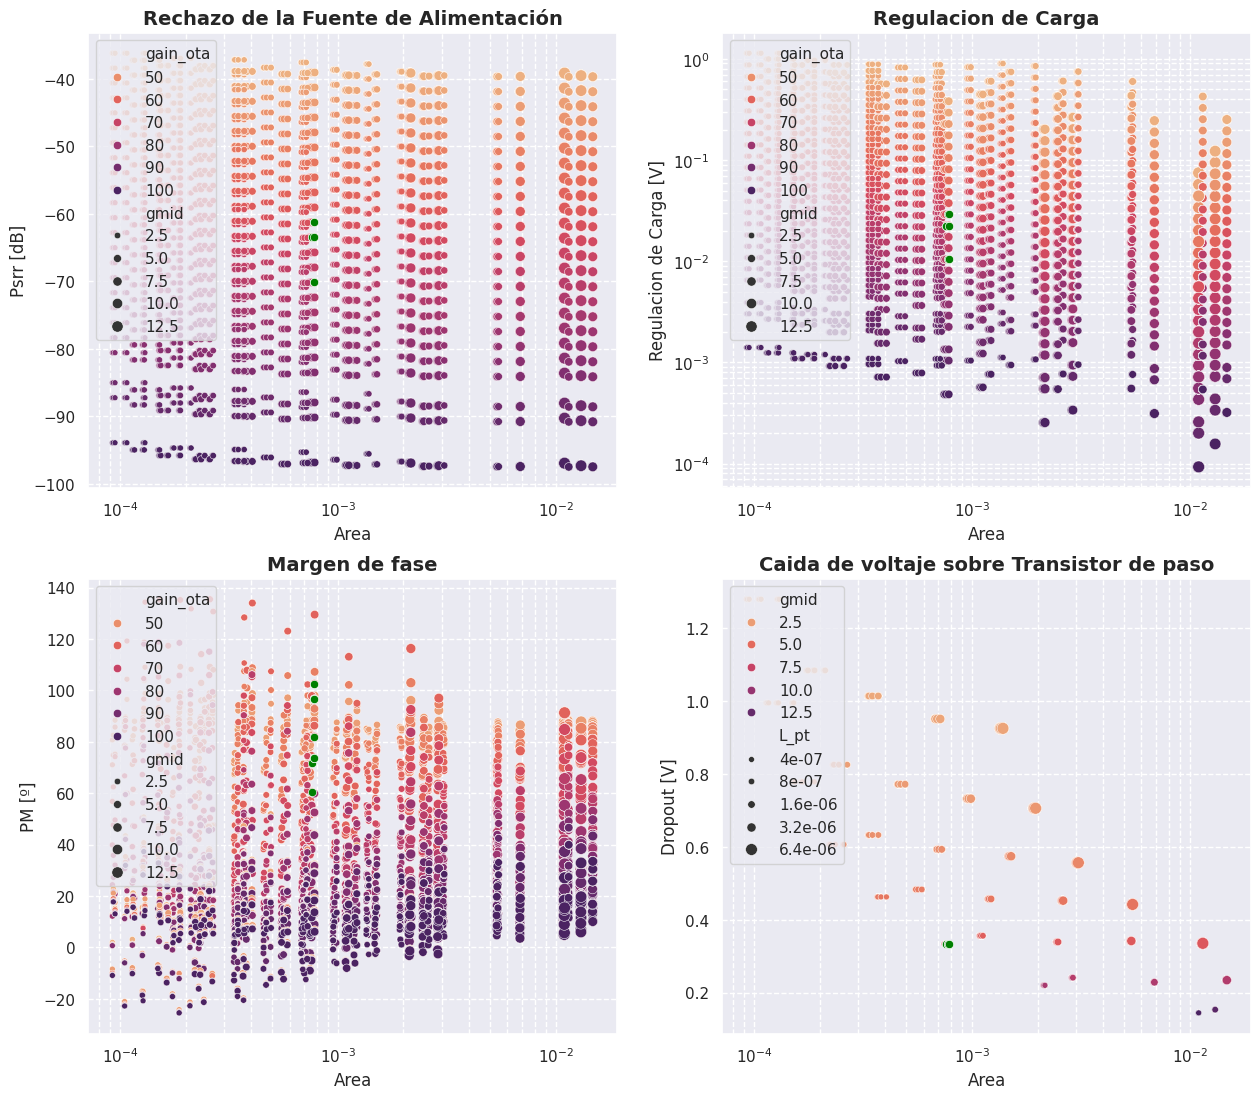

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df, x='area', y=('dropout'), palette='flare', hue='gmid', rasterized=True, size=('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "upper left")
sns.move_legend(axs[0,1], "upper left")
sns.move_legend(axs[1,0], "upper left")
sns.move_legend(axs[1,1], "upper left")

plt.savefig('ldo_explore_raw_sky.pdf')

# OTA 1stage

## Case 2

In [25]:
OTA_1stage_macro.ext_mask = None

OTA_1stage_macro.primitives = [diffpair_wc, activeload_wc, currentsource]
OTA_1stage_macro.submacromodels = [] 
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0
OTA_1stage_macro.run_pareto = True

_, _, _, ota_1stage_df_wc, mask = dfs(OTA_1stage_macro, debug = False)

############################################
Starting the exploration of:  OTA_1stage_macro
Netlist:  ota_1stage
Running MNA... 
MNA of gain_1stage took: 0.09172844886779785
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
MNA of rout_1stage took: 0.051309823989868164
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
MNA of gm_1stage took: 0.028519392013549805
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs

## Case 1

In [26]:
OTA_1stage_macro.ext_mask = mask

OTA_1stage_macro.primitives = [diffpair, activeload, currentsource]
OTA_1stage_macro.submacromodels = [] 
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0
OTA_1stage_macro.run_pareto = True

ota_1stage_results, ota_1stage_axes, ota_1stage_primouts, ota_1stage_df, _ = dfs(OTA_1stage_macro, debug = False)

############################################
Starting the exploration of:  ota_1stage
Netlist:  ota_1stage
Running MNA... 
MNA of gain_1stage took: 0.050197601318359375
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[('vout', 'vpos')]
Netlist:  ota_1stage_rout
Running MNA... 
MNA of rout_1stage took: 0.05670499801635742
   net1  vs  vneg  vout  vpos  vdd  vss  vr
0     1   2     3     4     5    6    0   7
[['vout', 'vr']]
Netlist:  ota_1stage
Running MNA... 
MNA of gm_1stage took: 0.025983810424804688
   net1  vs  vneg  vout  vpos  vdd  vss
0     1   2     3     4     5    6    0
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(-2*Raload_1**2*Rcs*Rdiff_1**2*gaload_1*gdiff_1**2 - 2*Raload_1**2*Rcs*Rdiff_1*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1**2*gaload_1*gdiff_1 - Raload_1**2*Rdiff_1*gdiff_1 - Raload_1*Rcs*Rdiff_1**2*gdiff_1**2 - Raload_1*Rcs*Rdiff_1*gdiff_1 - Raload_1*Rdiff_1**2*gdiff_1)/(2*Raload_1**2*Rcs*Rdiff

## Filtering

In [27]:
ota_1stage_df_wc["gain"] = 20*np.log10(ota_1stage_df_wc["gain_1stage"])
ota_1stage_df_wc.sort_values(by=Symbol("W_cs"))

gdiff_1       Rdiff_1  vs_diff  gaload_1      Raload_1  vout_aload  \
8154    0.000101  1.147164e+06    0.425  0.000083  1.278439e+05    1.471112   
1904    0.000113  6.575628e+05    0.425  0.000083  1.278439e+05    1.471112   
761779  0.000092  2.224030e+06    0.425  0.000040  1.054553e+07    1.097752   
5029    0.000108  8.660769e+05    0.425  0.000083  1.278439e+05    1.471112   
689154  0.000096  1.590427e+06    0.425  0.000039  1.092843e+07    1.085344   
...          ...           ...      ...       ...           ...         ...   
689020  0.000054  3.064636e+06    0.300  0.000039  1.092843e+07    1.085344   
761645  0.000051  4.233649e+06    0.300  0.000040  1.054553e+07    1.097752   
584645  0.000051  3.915650e+06    0.300  0.000023  1.790544e+07    0.853741   
673145  0.000051  4.196389e+06    0.300  0.000036  1.197157e+07    1.051456   
19395   0.000051  4.417864e+06    0.300  0.000083  1.278439e+05    1.471112   

             gcs            Rcs  vs_cs  vgs_cs  ...  gm_1stage    W_diff  \
8154    0.000031  195734.018570  0.425   1.025  ...   0.000096  0.000018   
1904    0.000031  195734.018570  0.425   1.025  ...   0.000108  0.000015   
761779  0.000031  195734.018570  0.425   1.025  ...   0.000091  0.000046   
5029    0.000031  195734.018570  0.425   1.025  ...   0.000103  0.000015   
689154  0.000031  195734.018570  0.425   1.025  ...   0.000095  0.000027   
...          ...            ...    ...     ...  ...        ...       ...   
689020  0.000325  500638.140501  0.300   0.100  ...   0.000054  0.000004   
761645  0.000325  500638.140501  0.300   0.100  ...   0.000051  0.000008   
584645  0.000325  500638.140501  0.300   0.100  ...   0.000051  0.000008   
673145  0.000325  500638.140501  0.300   0.100  ...   0.000051  0.000008   
19395   0.000325  500638.140501  0.300   0.100  ...   0.000049  0.000008   

              L_diff  vout_1stage      W_al          L_al          W_cs  \
8154    1.600000e-06     1.471112  0.000064  4.000000e-07  1.398493e-07   
1904    4.000000e-07     1.471112  0.000064  4.000000e-07  1.398493e-07   
761779  6.400000e-06     1.097752  0.000026  6.400000e-06  1.398493e-07   
5029    8.000000e-07     1.471112  0.000064  4.000000e-07  1.398493e-07   
689154  3.200000e-06     1.085344  0.000026  6.400000e-06  1.398493e-07   
...              ...          ...       ...           ...           ...   
689020  3.200000e-06     1.085344  0.000026  6.400000e-06  3.452557e+00   
761645  6.400000e-06     1.097752  0.000026  6.400000e-06  3.452557e+00   
584645  6.400000e-06     0.853741  0.000007  6.400000e-06  3.452557e+00   
673145  6.400000e-06     1.051456  0.000026  6.400000e-06  3.452557e+00   
19395   6.400000e-06     1.471112  0.000064  4.000000e-07  3.452557e+00   

                L_cs      area       gain  
8154    4.000000e-07  0.000085  20.936727  
1904    4.000000e-07  0.000080  21.311993  
761779  4.000000e-07  0.000085  44.554915  
5029    4.000000e-07  0.000081  21.242372  
689154  4.000000e-07  0.000064  42.504847  
...              ...       ...        ...  
689020  6.400000e-06  3.452603  42.235873  
761645  6.400000e-06  3.452610  43.778559  
584645  6.400000e-06  3.452591  44.351424  
673145  6.400000e-06  3.452610  44.030424  
19395   6.400000e-06  3.452642  15.638211  

[6125 rows x 22 columns]

In [28]:
ota_1stage_df["gain"] = 20*np.log10(ota_1stage_df["gain_1stage"])
ota_1stage_df["gain_wc"] = ota_1stage_df_wc["gain"]

ota_1stage_df = ota_1stage_df.dropna()

mask = (ota_1stage_df[Symbol("W_cs")]>5e-6) & (ota_1stage_df[Symbol("W_cs")]<1e-4) & (ota_1stage_df[Symbol("W_al")]<1e-4)
ota_1stage_df_new = ota_1stage_df[mask]


In [29]:
ota_1stage_df_new.to_csv("data/SKY_lv_ota_1stage_case1_98_10_10.csv", index=False)

In [30]:
ota_1stage_df_wc = ota_1stage_df_wc[mask]
ota_1stage_df_wc

gdiff_1       Rdiff_1  vs_diff  gaload_1      Raload_1  vout_aload  \
1917    0.000113  6.575628e+05    0.425  0.000083  1.278439e+05    1.471112   
1922    0.000113  6.575628e+05    0.425  0.000083  1.278439e+05    1.471112   
5042    0.000108  8.660769e+05    0.425  0.000083  1.278439e+05    1.471112   
5047    0.000108  8.660769e+05    0.425  0.000083  1.278439e+05    1.471112   
8167    0.000101  1.147164e+06    0.425  0.000083  1.278439e+05    1.471112   
...          ...           ...      ...       ...           ...         ...   
761642  0.000051  4.233649e+06    0.300  0.000040  1.054553e+07    1.097752   
761647  0.000051  4.233649e+06    0.300  0.000040  1.054553e+07    1.097752   
761648  0.000051  4.233649e+06    0.300  0.000040  1.054553e+07    1.097752   
761792  0.000092  2.224030e+06    0.425  0.000040  1.054553e+07    1.097752   
761797  0.000092  2.224030e+06    0.425  0.000040  1.054553e+07    1.097752   

             gcs           Rcs  vs_cs  vgs_cs  ...  gm_1stage    W_diff  \
1917    0.000098  1.326519e+06  0.425   0.625  ...   0.000108  0.000015   
1922    0.000092  1.752801e+06  0.425   0.625  ...   0.000108  0.000015   
5042    0.000098  1.326519e+06  0.425   0.625  ...   0.000103  0.000015   
5047    0.000092  1.752801e+06  0.425   0.625  ...   0.000103  0.000015   
8167    0.000098  1.326519e+06  0.425   0.625  ...   0.000096  0.000018   
...          ...           ...    ...     ...  ...        ...       ...   
761642  0.000176  7.457421e+05  0.300   0.500  ...   0.000051  0.000008   
761647  0.000166  1.000027e+06  0.300   0.500  ...   0.000051  0.000008   
761648  0.000069  4.815326e+05  0.300   0.700  ...   0.000051  0.000008   
761792  0.000098  1.326519e+06  0.425   0.625  ...   0.000091  0.000046   
761797  0.000092  1.752801e+06  0.425   0.625  ...   0.000091  0.000046   

              L_diff  vout_1stage      W_al          L_al      W_cs      L_cs  \
1917    4.000000e-07     1.471112  0.000064  4.000000e-07  0.000007  0.000003   
1922    4.000000e-07     1.471112  0.000064  4.000000e-07  0.000013  0.000006   
5042    8.000000e-07     1.471112  0.000064  4.000000e-07  0.000007  0.000003   
5047    8.000000e-07     1.471112  0.000064  4.000000e-07  0.000013  0.000006   
8167    1.600000e-06     1.471112  0.000064  4.000000e-07  0.000007  0.000003   
...              ...          ...       ...           ...       ...       ...   
761642  6.400000e-06     1.097752  0.000026  6.400000e-06  0.000036  0.000003   
761647  6.400000e-06     1.097752  0.000026  6.400000e-06  0.000061  0.000006   
761648  6.400000e-06     1.097752  0.000026  6.400000e-06  0.000007  0.000006   
761792  6.400000e-06     1.097752  0.000026  6.400000e-06  0.000007  0.000003   
761797  6.400000e-06     1.097752  0.000026  6.400000e-06  0.000013  0.000006   

            area       gain  
1917    0.000089  21.304659  
1922    0.000098  21.304344  
5042    0.000091  21.234697  
5047    0.000100  21.234367  
8167    0.000094  20.928541  
...          ...        ...  
761642  0.000086  43.778496  
761647  0.000114  43.778462  
761648  0.000060  43.778566  
761792  0.000095  44.554680  
761797  0.000104  44.554670  

[770 rows x 22 columns]

In [31]:
ota_1stage_df_wc.to_csv("data/SKY_lv_ota_1stage_case2_98_10_10.csv", index=False)

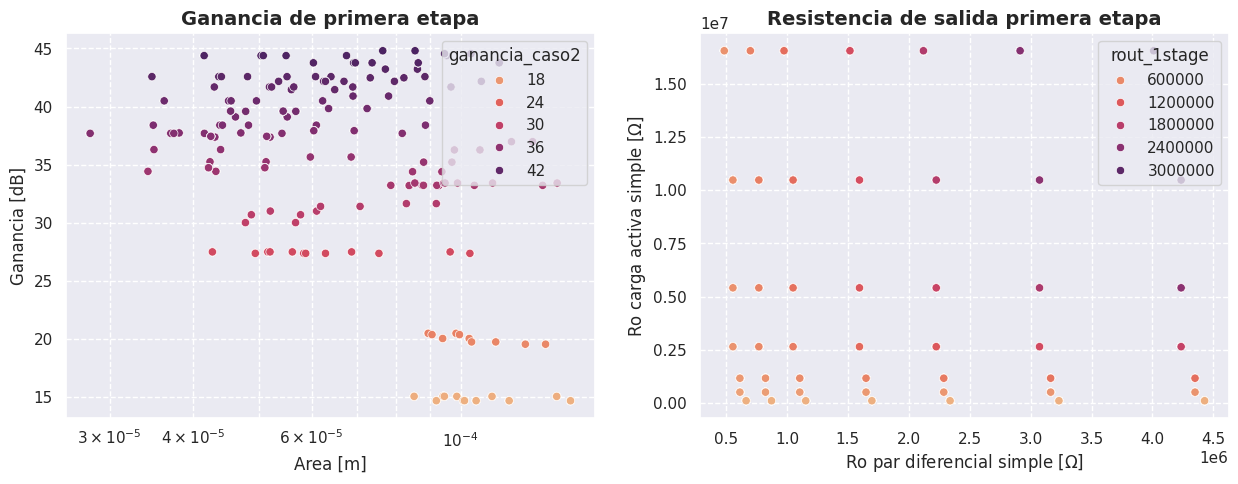

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axs[0], data=ota_1stage_df_new, x="area", y="gain", hue="gain_wc", palette='flare')
sns.scatterplot(ax=axs[1], data=ota_1stage_df_new, x=Symbol("Rdiff_1"), y=Symbol("Raload_1"), hue="rout_1stage", palette='flare')

axs[0].set_title(r"Ganancia de primera etapa", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Resistencia de salida primera etapa", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Ro par diferencial simple $[\Omega]$")
axs[1].set_ylabel(r"Ro carga activa simple $[\Omega]$")
axs[1].legend(loc = 'upper right')

axs[0].set_xscale('log')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  

sns.move_legend(axs[1], "upper right",title="rout_1stage")
sns.move_legend(axs[0], "upper right",title="ganancia_caso2")

plt.savefig('ota_1stage_explore.pdf')

# OTA 2stage 

## Case 2

In [33]:
OTA_2stage_macro.ext_mask = None

OTA_2stage_macro.primitives = [stage2_t_wc, stage2_cs_wc]
OTA_2stage_macro.submacromodels = [] 
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0
OTA_2stage_macro.run_pareto = True

_, _, _, ota_2stage_df_wc, mask = dfs(OTA_2stage_macro, debug = False)

############################################
Starting the exploration of:  OTA_2stage_macro
Netlist:  ota_2stage_v2
Running MNA... 
MNA of gain_2stage took: 0.06019186973571777
   vdd  vout  vin  vss
0    1     2    3    0
[('vout', 'vin')]
Netlist:  ota_2stage_rout_v2
Running MNA... 
MNA of rout_2stage took: 0.0516362190246582
   vr  vss  vout  vdd  vin
0   1    0     2    3    4
[['vout', 'vr']]
Netlist:  ota_2stage_v2
Running MNA... 
MNA of gm_2stage took: 0.02186274528503418
   vdd  vout  vin  vss
0    1     2    3    0
[['vout', 'vin']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Rcs_2stage*Ro_2stage*gm_2stage/(Rcs_2stage + Ro_2stage)
lambdify variables: (gm_2stage, Ro_2stage, Cin_2stage, gcs_2stage, Rcs_2stage, vgs_cs_2stage) <function _lambdifygenerated at 0x7effd689e050>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([4.86521080e-07, 1.38777698e-06, 3.11590537e-06, 6.88186557e-06,
       1.46400277e-05, 1.21150318e-06, 4.63

In [34]:
ota_2stage_df_wc["gain"] = 20*np.log10(ota_2stage_df_wc["gain_2stage"])
ota_2stage_df_wc_new = ota_2stage_df_wc[(ota_2stage_df_wc[Symbol("W_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_2stage")]>3e-6) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]>3e-6)]
ota_2stage_df_wc_new.sort_values(by=Symbol("W_2stage"))

gm_2stage      Ro_2stage    Cin_2stage  gcs_2stage    Rcs_2stage  \
52     0.000040   67127.567689  3.136576e-14    0.000213  4.063876e+05   
3027   0.000040   67127.567689  3.136576e-14    0.000051  4.062825e+06   
452    0.000040   67127.567689  3.136576e-14    0.000071  2.348552e+06   
552    0.000040   67127.567689  3.136576e-14    0.000161  1.399002e+06   
2402   0.000040   67127.567689  3.136576e-14    0.000075  2.946020e+06   
...         ...            ...           ...         ...           ...   
563    0.000151  735617.503927  2.208998e-12    0.000161  1.399002e+06   
463    0.000151  735617.503927  2.208998e-12    0.000071  2.348552e+06   
2388   0.000151  735617.503927  2.208998e-12    0.000180  1.217187e+06   
63     0.000151  735617.503927  2.208998e-12    0.000213  4.063876e+05   
3038   0.000151  735617.503927  2.208998e-12    0.000051  4.062825e+06   

      vgs_cs_2stage  gain_2stage    rout_2stage  gm_2stage  W_2stage  \
52            0.500     2.301293   57611.271102   0.000040  0.000003   
3027          0.800     2.637840   66036.487147   0.000040  0.000003   
452           0.700     2.606911   65262.208712   0.000040  0.000003   
552           0.500     2.558653   64054.093254   0.000040  0.000003   
2402          0.675     2.621686   65632.084973   0.000040  0.000003   
...             ...          ...            ...        ...       ...   
563           0.500    72.739719  482114.138781   0.000151  0.000225   
463           0.700    84.515384  560162.478420   0.000151  0.000225   
2388          0.475    69.178692  458511.881027   0.000151  0.000225   
63            0.500    39.495369  261772.744690   0.000151  0.000225   
3038          0.800    93.972682  622844.834977   0.000151  0.000225   

      L_2stage  vin_2stage  W_cs_2stage   L_cs_2stage      area       gain  
52    0.000002    0.867342     0.000022  4.000000e-07  0.000027   7.239439  
3027  0.000002    0.867342     0.000004  6.400000e-06  0.000015   8.424969  
452   0.000002    0.867342     0.000004  3.200000e-06  0.000012   8.322525  
552   0.000002    0.867342     0.000061  6.400000e-06  0.000072   8.160228  
2402  0.000002    0.867342     0.000008  6.400000e-06  0.000019   8.371614  
...        ...         ...          ...           ...       ...        ...  
563   0.000003    1.297777     0.000061  6.400000e-06  0.000296  37.235432  
463   0.000003    1.297777     0.000004  3.200000e-06  0.000235  38.538715  
2388  0.000003    1.297777     0.000091  6.400000e-06  0.000326  36.799447  
63    0.000003    1.297777     0.000022  4.000000e-07  0.000251  31.930924  
3038  0.000003    1.297777     0.000004  6.400000e-06  0.000239  39.460032  

[408 rows x 16 columns]

## Case 1

In [35]:
OTA_2stage_macro.ext_mask = mask

OTA_2stage_macro.primitives = [stage2_t, stage2_cs]
OTA_2stage_macro.submacromodels = [] 
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0
OTA_2stage_macro.run_pareto = True

_, _, _, ota_2stage_df, _ = dfs(OTA_2stage_macro, debug = False)

############################################
Starting the exploration of:  ota_2stage_v2
Netlist:  ota_2stage_v2
Running MNA... 
MNA of gain_2stage took: 0.029680490493774414
   vdd  vout  vin  vss
0    1     2    3    0
[('vout', 'vin')]
Netlist:  ota_2stage_rout_v2
Running MNA... 
MNA of rout_2stage took: 0.02632761001586914
   vr  vss  vout  vdd  vin
0   1    0     2    3    4
[['vout', 'vr']]
Netlist:  ota_2stage_v2
Running MNA... 
MNA of gm_2stage took: 0.02260589599609375
   vdd  vout  vin  vss
0    1     2    3    0
[['vout', 'vin']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Rcs_2stage*Ro_2stage*gm_2stage/(Rcs_2stage + Ro_2stage)
lambdify variables: (gm_2stage, Ro_2stage, Cin_2stage, gcs_2stage, Rcs_2stage, vgs_cs_2stage) <function _lambdifygenerated at 0x7effd6b6caf0>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([4.86521080e-07, 1.38777698e-06, 3.11590537e-06, 6.88186557e-06,
       1.46400277e-05, 1.21150318e-06, 4.630

In [36]:
ota_2stage_df["gain"] = 20*np.log10(ota_2stage_df["gain_2stage"])
ota_2stage_df_new = ota_2stage_df[(ota_2stage_df_wc[Symbol("W_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_2stage")]>3e-6) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]<3e-4) & (ota_2stage_df_wc[Symbol("W_cs_2stage")]>3e-6)]
ota_2stage_df_new

gm_2stage     Ro_2stage    Cin_2stage  gcs_2stage    Rcs_2stage  \
52     0.000050  1.418006e+06  2.969312e-14    0.000216  3.614087e+05   
53     0.000050  2.595249e+06  1.385491e-13    0.000216  3.614087e+05   
54     0.000051  5.124836e+06  6.399718e-13    0.000216  3.614087e+05   
56     0.000077  5.545358e+05  1.781634e-14    0.000216  3.614087e+05   
57     0.000082  1.304743e+06  8.370936e-14    0.000216  3.614087e+05   
...         ...           ...           ...         ...           ...   
3035   0.000099  1.499846e+05  7.902724e-15    0.000051  3.903530e+06   
3036   0.000141  2.875791e+05  8.692485e-14    0.000051  3.903530e+06   
3037   0.000153  6.357379e+05  4.696648e-13    0.000051  3.903530e+06   
3038   0.000151  1.359389e+06  2.035330e-12    0.000051  3.903530e+06   
3040   0.000170  9.826109e+04  6.979471e-14    0.000051  3.903530e+06   

      vgs_cs_2stage  gain_2stage   rout_2stage  gm_2stage  W_2stage  \
52              0.5    14.386936  2.880046e+05   0.000050  0.000003   
53              0.5    15.858570  3.172317e+05   0.000050  0.000007   
54              0.5    17.215476  3.376007e+05   0.000051  0.000015   
56              0.5    16.918111  2.188059e+05   0.000077  0.000005   
57              0.5    23.101712  2.830147e+05   0.000082  0.000011   
...             ...          ...           ...        ...       ...   
3035            0.8    14.366924  1.444350e+05   0.000099  0.000005   
3036            0.8    37.829655  2.678465e+05   0.000141  0.000039   
3037            0.8    83.641073  5.467009e+05   0.000153  0.000109   
3038            0.8   151.935128  1.008265e+06   0.000151  0.000225   
3040            0.8    16.314900  9.584836e+04   0.000170  0.000078   

          L_2stage  vin_2stage  W_cs_2stage   L_cs_2stage      area       gain  
52    1.600000e-06         0.9     0.000022  4.000000e-07  0.000027  23.159366  
53    3.200000e-06         0.9     0.000022  4.000000e-07  0.000032  24.005280  
54    6.400000e-06         0.9     0.000022  4.000000e-07  0.000043  24.718381  
56    8.000000e-07         1.1     0.000022  4.000000e-07  0.000028  24.567038  
57    1.600000e-06         1.1     0.000022  4.000000e-07  0.000035  27.272883  
...            ...         ...          ...           ...       ...        ...  
3035  4.000000e-07         1.3     0.000004  6.400000e-06  0.000016  23.147276  
3036  8.000000e-07         1.3     0.000004  6.400000e-06  0.000050  31.556647  
3037  1.600000e-06         1.3     0.000004  6.400000e-06  0.000121  38.448392  
3038  3.200000e-06         1.3     0.000004  6.400000e-06  0.000239  43.633164  
3040  4.000000e-07         1.5     0.000004  6.400000e-06  0.000089  24.251688  

[408 rows x 16 columns]

## filtering

In [37]:
mask = (ota_2stage_df["gain"]>15) & (ota_2stage_df[Symbol("W_2stage")]<1e-4) & (ota_2stage_df[Symbol("W_cs_2stage")]>5e-6) & (ota_2stage_df[Symbol("W_cs_2stage")]<1e-4)
ota_2stage_df_new = ota_2stage_df_new[mask]
ota_2stage_df_wc_new = ota_2stage_df_wc_new[mask]

/tmp/ipykernel_11702/533869183.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota_2stage_df_new = ota_2stage_df_new[mask]
/tmp/ipykernel_11702/533869183.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ota_2stage_df_wc_new = ota_2stage_df_wc_new[mask]


In [38]:
ota_2stage_df_new["gain_wc"] = ota_2stage_df_wc_new["gain"]
ota_2stage_df_new

/tmp/ipykernel_11702/3031976428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ota_2stage_df_new["gain_wc"] = ota_2stage_df_wc_new["gain"]


gm_2stage     Ro_2stage    Cin_2stage  gcs_2stage    Rcs_2stage  \
52     0.000050  1.418006e+06  2.969312e-14    0.000216  3.614087e+05   
53     0.000050  2.595249e+06  1.385491e-13    0.000216  3.614087e+05   
54     0.000051  5.124836e+06  6.399718e-13    0.000216  3.614087e+05   
56     0.000077  5.545358e+05  1.781634e-14    0.000216  3.614087e+05   
57     0.000082  1.304743e+06  8.370936e-14    0.000216  3.614087e+05   
...         ...           ...           ...         ...           ...   
3008   0.000080  2.645694e+06  3.863504e-13    0.000102  2.199513e+06   
3009   0.000081  5.121751e+06  1.754058e-12    0.000102  2.199513e+06   
3010   0.000099  1.499846e+05  7.902724e-15    0.000102  2.199513e+06   
3011   0.000141  2.875791e+05  8.692485e-14    0.000102  2.199513e+06   
3015   0.000170  9.826109e+04  6.979471e-14    0.000102  2.199513e+06   

      vgs_cs_2stage  gain_2stage   rout_2stage  gm_2stage  W_2stage  \
52              0.5    14.386936  2.880046e+05   0.000050  0.000003   
53              0.5    15.858570  3.172317e+05   0.000050  0.000007   
54              0.5    17.215476  3.376007e+05   0.000051  0.000015   
56              0.5    16.918111  2.188059e+05   0.000077  0.000005   
57              0.5    23.101712  2.830147e+05   0.000082  0.000011   
...             ...          ...           ...        ...       ...   
3008            0.6    95.936598  1.201030e+06   0.000080  0.000024   
3009            0.6   125.105904  1.538718e+06   0.000081  0.000052   
3010            0.6    13.966563  1.404101e+05   0.000099  0.000005   
3011            0.6    35.920179  2.543267e+05   0.000141  0.000039   
3015            0.6    16.010338  9.405909e+04   0.000170  0.000078   

          L_2stage  vin_2stage  W_cs_2stage   L_cs_2stage      area  \
52    1.600000e-06         0.9     0.000022  4.000000e-07  0.000027   
53    3.200000e-06         0.9     0.000022  4.000000e-07  0.000032   
54    6.400000e-06         0.9     0.000022  4.000000e-07  0.000043   
56    8.000000e-07         1.1     0.000022  4.000000e-07  0.000028   
57    1.600000e-06         1.1     0.000022  4.000000e-07  0.000035   
...            ...         ...          ...           ...       ...   
3008  3.200000e-06         1.1     0.000016  6.400000e-06  0.000050   
3009  6.400000e-06         1.1     0.000016  6.400000e-06  0.000081   
3010  4.000000e-07         1.3     0.000016  6.400000e-06  0.000028   
3011  8.000000e-07         1.3     0.000016  6.400000e-06  0.000062   
3015  4.000000e-07         1.5     0.000016  6.400000e-06  0.000101   

           gain    gain_wc  
52    23.159366   7.239439  
53    24.005280   8.772005  
54    24.718381  10.586221  
56    24.567038  17.622138  
57    27.272883  21.067226  
...         ...        ...  
3008  39.639686  26.611923  
3009  41.945556  30.948448  
3010  22.901791  18.543429  
3011  31.106770  28.150685  
3015  24.088010  19.814388  

[220 rows x 17 columns]

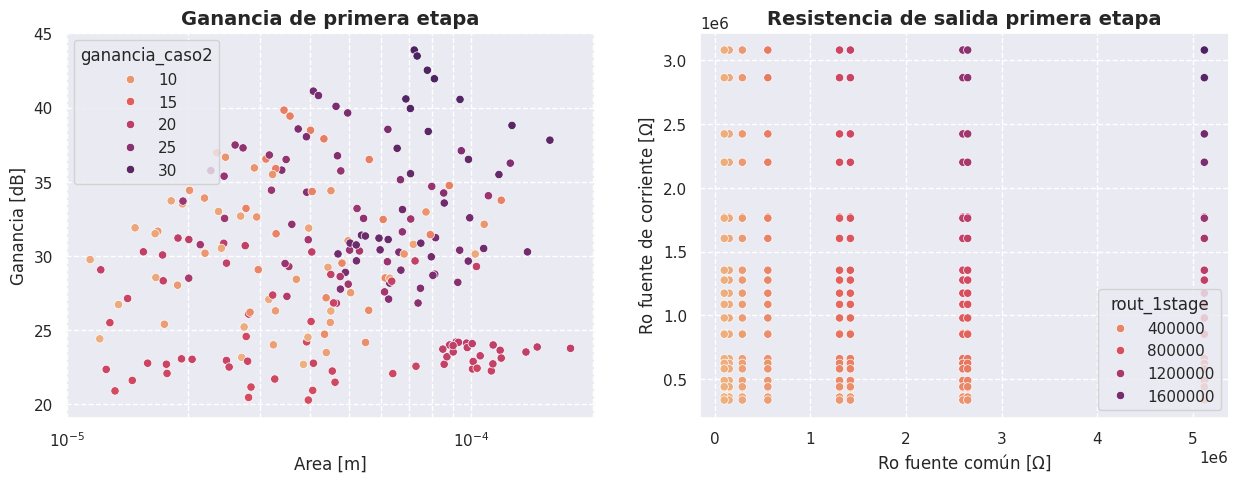

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(ax=axs[0], data=ota_2stage_df_new, x="area", y="gain", palette='flare', hue="gain_wc")
sns.scatterplot(ax=axs[1], data=ota_2stage_df_new, x=Symbol("Ro_2stage"), y=Symbol("Rcs_2stage"), hue="rout_2stage", palette='flare')

axs[0].set_title(r"Ganancia de primera etapa", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Resistencia de salida primera etapa", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Ro fuente común $[\Omega]$")
axs[1].set_ylabel(r"Ro fuente de corriente $[\Omega]$")
axs[1].legend(loc = 'upper right')

axs[0].set_xscale('log')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  

sns.move_legend(axs[1], "lower right",title="rout_1stage")
sns.move_legend(axs[0], "upper left",title="ganancia_caso2")

plt.savefig('ota_2stage_explore.pdf')

In [40]:
ota_2stage_df_new.to_csv("data/SKY_lv_ota_2stage_case1.csv", index=False)
ota_2stage_df_wc_new.to_csv("data/SKY_lv_ota_2stage_case2.csv", index=False)

# OTA exploration 3

In [41]:
ota_1stage_df_new = pd.read_csv("data/SKY_lv_ota_1stage_case1_98_10_10.csv")
#ota_1stage_df_new = ota_1stage_df_new.sort_values(by="gain").drop_duplicates()
print(len(ota_1stage_df_new))

ota_2stage_df_new = pd.read_csv("data/SKY_lv_ota_2stage_case1.csv")
#mask = (ota_2stage_df_new["Ro_2stage"]>10000) & (ota_2stage_df_new["Ro_2stage"]<1000000)
#ota_2stage_df_new = ota_2stage_df_new[mask]
print(len(ota_2stage_df_new))

770
220


In [42]:
ota_1stage_df_wc_new = pd.read_csv("data/SKY_lv_ota_1stage_case2_98_10_10.csv")
print(len(ota_1stage_df_wc_new))

ota_2stage_df_wc_new = pd.read_csv("data/SKY_lv_ota_2stage_case2.csv")
#ota_2stage_df_wc_new = ota_2stage_df_wc_new[mask]
print(len(ota_2stage_df_wc_new))

770
220


In [43]:
OTA_2stage_primitive_wc = Primitive(parameters={Symbol("Ra_2stage"): ota_2stage_df_wc_new["rout_2stage"].values,
                                  Symbol("gma_2stage"): ota_2stage_df_wc_new["gm_2stage"].values,
                                  Symbol("Cin_2stage"): ota_2stage_df_wc_new["Cin_2stage"].values})

OTA_2stage_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_2stage_df_wc_new["W_2stage"].values,
    Symbol("L_2stage"): ota_2stage_df_wc_new["L_2stage"].values,
    Symbol("vin_2stage"): ota_2stage_df_wc_new["vin_2stage"].values,
    Symbol("W_cs_2stage"): ota_2stage_df_wc_new["W_cs_2stage"].values,
    Symbol("L_cs_2stage"): ota_2stage_df_wc_new["L_cs_2stage"].values,
    Symbol("vgs_cs_2stage"): ota_2stage_df_wc_new["vgs_cs_2stage"].values}

OTA_1stage_primitive_wc = Primitive(parameters={
    Symbol("Ra_1stage"): ota_1stage_df_wc_new["rout_1stage"].values,
    Symbol("gma_1stage"): ota_1stage_df_wc_new["gm_1stage"].values})
OTA_1stage_primitive_wc.outputs = {
    Symbol("W_diff"): ota_1stage_df_wc_new["W_diff"].values,
    Symbol("L_diff"): ota_1stage_df_wc_new["L_diff"].values,
    Symbol("vout_1stage"): ota_1stage_df_wc_new["vout_1stage"].values,
    Symbol("W_al"): ota_1stage_df_wc_new["W_al"].values,
    Symbol("L_al"): ota_1stage_df_wc_new["L_al"].values,
    Symbol("W_cs"): ota_1stage_df_wc_new["W_cs"].values,
    Symbol("L_cs"): ota_1stage_df_wc_new["L_cs"].values,
    Symbol("vgs_cs"): ota_1stage_df_wc_new["vgs_cs"].values}

In [44]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt_wc}

rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): Cin_pt_wc}

OTA_macro.ext_mask = None

OTA_macro.primitives = [OTA_2stage_primitive_wc, OTA_1stage_primitive_wc, Cc_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, mask_ota = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OTA_macro
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.05204439163208008
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.05311274528503418
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.03144502639770508
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7effd413e7a0>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([3.11590537e-06, 6.88186557e-06, 1.46400277e-05, 4.63071496e-06,
       1.10737523e-05, 2.4106391

In [45]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df_wc

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
621       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
622       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
623       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
624       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
625       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
...                ...         ...           ...           ...         ...   
1523308  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   
1523309  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   
1523310  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   
1523311  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   
1523312  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   

                   Cc        Rc     gain_OTA       rout_OTA    gm_OTA  ...  \
621      1.000000e-13    1000.0   113.061628   58295.056599  0.001939  ...   
622      3.162278e-12    1000.0   113.061628   58295.056599  0.001939  ...   
623      1.000000e-10    1000.0   113.061628   58295.056599  0.001939  ...   
624      1.000000e-13   10000.0   113.061628   58295.056599  0.001939  ...   
625      3.162278e-12   10000.0   113.061628   58295.056599  0.001939  ...   
...               ...       ...          ...            ...       ...  ...   
1523308  3.162278e-12   10000.0  6067.450489  449109.245285  0.013510  ...   
1523309  1.000000e-10   10000.0  6067.450489  449109.245285  0.013510  ...   
1523310  1.000000e-13  100000.0  6067.450489  449109.245285  0.013510  ...   
1523311  3.162278e-12  100000.0  6067.450489  449109.245285  0.013510  ...   
1523312  1.000000e-10  100000.0  6067.450489  449109.245285  0.013510  ...   

                 L_al      W_cs      L_cs  vgs_cs      W_cc      L_cc  \
621      4.000000e-07  0.000007  0.000003   0.625  0.000008  0.000008   
622      4.000000e-07  0.000007  0.000003   0.625  0.000046  0.000046   
623      4.000000e-07  0.000007  0.000003   0.625  0.000258  0.000258   
624      4.000000e-07  0.000007  0.000003   0.625  0.000008  0.000008   
625      4.000000e-07  0.000007  0.000003   0.625  0.000046  0.000046   
...               ...       ...       ...     ...       ...       ...   
1523308  6.400000e-06  0.000013  0.000006   0.625  0.000046  0.000046   
1523309  6.400000e-06  0.000013  0.000006   0.625  0.000258  0.000258   
1523310  6.400000e-06  0.000013  0.000006   0.625  0.000008  0.000008   
1523311  6.400000e-06  0.000013  0.000006   0.625  0.000046  0.000046   
1523312  6.400000e-06  0.000013  0.000006   0.625  0.000258  0.000258   

             W_rc          L_rc      area       gain  
621      0.000001  5.000000e-07  0.000196  41.066305  
622      0.000001  5.000000e-07  0.000271  41.066305  
623      0.000001  5.000000e-07  0.000696  41.066305  
624      0.000004  5.000000e-07  0.000199  41.066305  
625      0.000004  5.000000e-07  0.000274  41.066305  
...           ...           ...       ...        ...  
1523308  0.000004  5.000000e-07  0.000278  75.660125  
1523309  0.000004  5.000000e-07  0.000702  75.660125  
1523310  0.000012  5.000000e-07  0.000210  75.660125  
1523311  0.000012  5.000000e-07  0.000286  75.660125  
1523312  0.000012  5.000000e-07  0.000711  75.660125  

[3960 rows x 30 columns]

In [46]:
OTA_2stage_primitive = Primitive(parameters={Symbol("Ra_2stage"): ota_2stage_df_new["rout_2stage"].values,
                                  Symbol("gma_2stage"): ota_2stage_df_new["gm_2stage"].values,
                                  Symbol("Cin_2stage"): ota_2stage_df_new["Cin_2stage"].values})

OTA_2stage_primitive.outputs = {
    Symbol("W_2stage"): ota_2stage_df_new["W_2stage"].values,
    Symbol("L_2stage"): ota_2stage_df_new["L_2stage"].values,
    Symbol("vin_2stage"): ota_2stage_df_new["vin_2stage"].values,
    Symbol("W_cs_2stage"): ota_2stage_df_new["W_cs_2stage"].values,
    Symbol("L_cs_2stage"): ota_2stage_df_new["L_cs_2stage"].values,
    Symbol("vgs_cs_2stage"): ota_2stage_df_new["vgs_cs_2stage"].values}

OTA_1stage_primitive = Primitive(parameters={
    Symbol("Ra_1stage"): ota_1stage_df_new["rout_1stage"].values,
    Symbol("gma_1stage"): ota_1stage_df_new["gm_1stage"].values})
OTA_1stage_primitive.outputs = {
    Symbol("W_diff"): ota_1stage_df_new["W_diff"].values,
    Symbol("L_diff"): ota_1stage_df_new["L_diff"].values,
    Symbol("vout_1stage"): ota_1stage_df_new["vout_1stage"].values,
    Symbol("W_al"): ota_1stage_df_new["W_al"].values,
    Symbol("L_al"): ota_1stage_df_new["L_al"].values,
    Symbol("W_cs"): ota_1stage_df_new["W_cs"].values,
    Symbol("L_cs"): ota_1stage_df_new["L_cs"].values,
    Symbol("vgs_cs"): ota_1stage_df_new["vgs_cs"].values}

In [47]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt}

rout_OTA.parametros = {
    Symbol("Vpos"): 0,
    Symbol("Vr"): 1,
    Symbol("s"): 0,
    Symbol("Rr"): 1000,
    Symbol("Cin_pt"): Cin_pt}

OTA_macro.ext_mask = mask_ota

OTA_macro.primitives = [OTA_2stage_primitive, OTA_1stage_primitive, Cc_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.023075580596923828
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.02661752700805664
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.03006577491760254
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7effd413f130>
#### creating the primods_list ####
primmods_outputs_aux:  {W_2stage: array([3.11590537e-06, 6.88186557e-06, 1.46400277e-05, 4.63071496e-06,
       1.10737523e-05, 2.410

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219], [0, 1, 

In [48]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
621      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
622      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
623      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
624      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
625      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
...               ...         ...           ...           ...         ...   
1523308  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523309  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523310  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523311  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523312  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   

                   Cc        Rc      gain_OTA      rout_OTA    gm_OTA  ...  \
621      1.000000e-13    1000.0    167.400022  9.309395e+04  0.001798  ...   
622      3.162278e-12    1000.0    167.400022  9.309395e+04  0.001798  ...   
623      1.000000e-10    1000.0    167.400022  9.309395e+04  0.001798  ...   
624      1.000000e-13   10000.0    167.400022  9.309395e+04  0.001798  ...   
625      3.162278e-12   10000.0    167.400022  9.309395e+04  0.001798  ...   
...               ...       ...           ...           ...       ...  ...   
1523308  3.162278e-12   10000.0  22565.828502  1.644095e+06  0.013725  ...   
1523309  1.000000e-10   10000.0  22565.828502  1.644095e+06  0.013725  ...   
1523310  1.000000e-13  100000.0  22565.828502  1.644095e+06  0.013725  ...   
1523311  3.162278e-12  100000.0  22565.828502  1.644095e+06  0.013725  ...   
1523312  1.000000e-10  100000.0  22565.828502  1.644095e+06  0.013725  ...   

                 L_al      W_cs      L_cs  vgs_cs      W_cc      L_cc  \
621      4.000000e-07  0.000007  0.000003   0.625  0.000008  0.000008   
622      4.000000e-07  0.000007  0.000003   0.625  0.000046  0.000046   
623      4.000000e-07  0.000007  0.000003   0.625  0.000258  0.000258   
624      4.000000e-07  0.000007  0.000003   0.625  0.000008  0.000008   
625      4.000000e-07  0.000007  0.000003   0.625  0.000046  0.000046   
...               ...       ...       ...     ...       ...       ...   
1523308  6.400000e-06  0.000013  0.000006   0.625  0.000046  0.000046   
1523309  6.400000e-06  0.000013  0.000006   0.625  0.000258  0.000258   
1523310  6.400000e-06  0.000013  0.000006   0.625  0.000008  0.000008   
1523311  6.400000e-06  0.000013  0.000006   0.625  0.000046  0.000046   
1523312  6.400000e-06  0.000013  0.000006   0.625  0.000258  0.000258   

             W_rc          L_rc      area       gain  
621      0.000001  5.000000e-07  0.000196  44.475110  
622      0.000001  5.000000e-07  0.000271  44.475110  
623      0.000001  5.000000e-07  0.000696  44.475110  
624      0.000004  5.000000e-07  0.000199  44.475110  
625      0.000004  5.000000e-07  0.000274  44.475110  
...           ...           ...       ...        ...  
1523308  0.000004  5.000000e-07  0.000278  87.069026  
1523309  0.000004  5.000000e-07  0.000702  87.069026  
1523310  0.000012  5.000000e-07  0.000210  87.069026  
1523311  0.000012  5.000000e-07  0.000286  87.069026  
1523312  0.000012  5.000000e-07  0.000711  87.069026  

[19800 rows x 30 columns]

In [49]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df = ota_df.dropna()
ota_df

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
621      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
622      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
623      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
624      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
625      9.309395e+04    0.000170  6.979471e-14  9.833847e+04    0.000107   
...               ...         ...           ...           ...         ...   
1523308  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523309  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523310  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523311  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523312  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   

                   Cc        Rc      gain_OTA      rout_OTA    gm_OTA  ...  \
621      1.000000e-13    1000.0    167.400022  9.309395e+04  0.001798  ...   
622      3.162278e-12    1000.0    167.400022  9.309395e+04  0.001798  ...   
623      1.000000e-10    1000.0    167.400022  9.309395e+04  0.001798  ...   
624      1.000000e-13   10000.0    167.400022  9.309395e+04  0.001798  ...   
625      3.162278e-12   10000.0    167.400022  9.309395e+04  0.001798  ...   
...               ...       ...           ...           ...       ...  ...   
1523308  3.162278e-12   10000.0  22565.828502  1.644095e+06  0.013725  ...   
1523309  1.000000e-10   10000.0  22565.828502  1.644095e+06  0.013725  ...   
1523310  1.000000e-13  100000.0  22565.828502  1.644095e+06  0.013725  ...   
1523311  3.162278e-12  100000.0  22565.828502  1.644095e+06  0.013725  ...   
1523312  1.000000e-10  100000.0  22565.828502  1.644095e+06  0.013725  ...   

             W_cs      L_cs  vgs_cs      W_cc      L_cc      W_rc  \
621      0.000007  0.000003   0.625  0.000008  0.000008  0.000001   
622      0.000007  0.000003   0.625  0.000046  0.000046  0.000001   
623      0.000007  0.000003   0.625  0.000258  0.000258  0.000001   
624      0.000007  0.000003   0.625  0.000008  0.000008  0.000004   
625      0.000007  0.000003   0.625  0.000046  0.000046  0.000004   
...           ...       ...     ...       ...       ...       ...   
1523308  0.000013  0.000006   0.625  0.000046  0.000046  0.000004   
1523309  0.000013  0.000006   0.625  0.000258  0.000258  0.000004   
1523310  0.000013  0.000006   0.625  0.000008  0.000008  0.000012   
1523311  0.000013  0.000006   0.625  0.000046  0.000046  0.000012   
1523312  0.000013  0.000006   0.625  0.000258  0.000258  0.000012   

                 L_rc      area       gain    gain_wc  
621      5.000000e-07  0.000196  44.475110  41.066305  
622      5.000000e-07  0.000271  44.475110  41.066305  
623      5.000000e-07  0.000696  44.475110  41.066305  
624      5.000000e-07  0.000199  44.475110  41.066305  
625      5.000000e-07  0.000274  44.475110  41.066305  
...               ...       ...        ...        ...  
1523308  5.000000e-07  0.000278  87.069026  75.660125  
1523309  5.000000e-07  0.000702  87.069026  75.660125  
1523310  5.000000e-07  0.000210  87.069026  75.660125  
1523311  5.000000e-07  0.000286  87.069026  75.660125  
1523312  5.000000e-07  0.000711  87.069026  75.660125  

[3960 rows x 31 columns]

In [50]:
ota_df_wc["gain"] = 20*np.log10(ota_df_wc["gain_OTA"])
ota_df_wc

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
621       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
622       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
623       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
624       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
625       58295.056599    0.000167  7.285932e-14  1.079275e+05    0.000108   
...                ...         ...           ...           ...         ...   
1523308  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   
1523309  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   
1523310  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   
1523311  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   
1523312  449109.245285    0.000080  1.852635e-12  1.846847e+06    0.000091   

                   Cc        Rc     gain_OTA       rout_OTA    gm_OTA  ...  \
621      1.000000e-13    1000.0   113.061628   58295.056599  0.001939  ...   
622      3.162278e-12    1000.0   113.061628   58295.056599  0.001939  ...   
623      1.000000e-10    1000.0   113.061628   58295.056599  0.001939  ...   
624      1.000000e-13   10000.0   113.061628   58295.056599  0.001939  ...   
625      3.162278e-12   10000.0   113.061628   58295.056599  0.001939  ...   
...               ...       ...          ...            ...       ...  ...   
1523308  3.162278e-12   10000.0  6067.450489  449109.245285  0.013510  ...   
1523309  1.000000e-10   10000.0  6067.450489  449109.245285  0.013510  ...   
1523310  1.000000e-13  100000.0  6067.450489  449109.245285  0.013510  ...   
1523311  3.162278e-12  100000.0  6067.450489  449109.245285  0.013510  ...   
1523312  1.000000e-10  100000.0  6067.450489  449109.245285  0.013510  ...   

                 L_al      W_cs      L_cs  vgs_cs      W_cc      L_cc  \
621      4.000000e-07  0.000007  0.000003   0.625  0.000008  0.000008   
622      4.000000e-07  0.000007  0.000003   0.625  0.000046  0.000046   
623      4.000000e-07  0.000007  0.000003   0.625  0.000258  0.000258   
624      4.000000e-07  0.000007  0.000003   0.625  0.000008  0.000008   
625      4.000000e-07  0.000007  0.000003   0.625  0.000046  0.000046   
...               ...       ...       ...     ...       ...       ...   
1523308  6.400000e-06  0.000013  0.000006   0.625  0.000046  0.000046   
1523309  6.400000e-06  0.000013  0.000006   0.625  0.000258  0.000258   
1523310  6.400000e-06  0.000013  0.000006   0.625  0.000008  0.000008   
1523311  6.400000e-06  0.000013  0.000006   0.625  0.000046  0.000046   
1523312  6.400000e-06  0.000013  0.000006   0.625  0.000258  0.000258   

             W_rc          L_rc      area       gain  
621      0.000001  5.000000e-07  0.000196  41.066305  
622      0.000001  5.000000e-07  0.000271  41.066305  
623      0.000001  5.000000e-07  0.000696  41.066305  
624      0.000004  5.000000e-07  0.000199  41.066305  
625      0.000004  5.000000e-07  0.000274  41.066305  
...           ...           ...       ...        ...  
1523308  0.000004  5.000000e-07  0.000278  75.660125  
1523309  0.000004  5.000000e-07  0.000702  75.660125  
1523310  0.000012  5.000000e-07  0.000210  75.660125  
1523311  0.000012  5.000000e-07  0.000286  75.660125  
1523312  0.000012  5.000000e-07  0.000711  75.660125  

[3960 rows x 30 columns]

In [51]:
mask = ota_df["gain"]>64.44
ota_df = ota_df[mask]
ota_df_wc = ota_df_wc[mask]

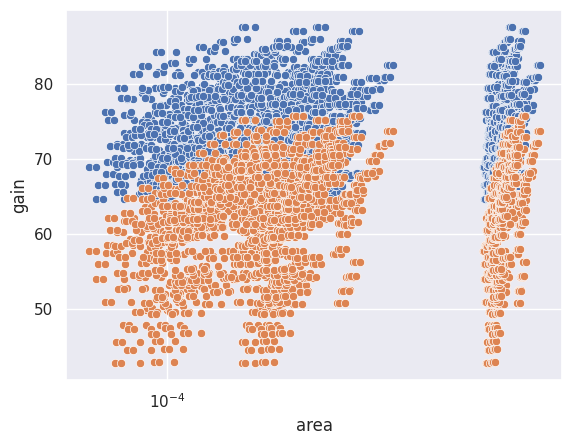

In [52]:
sns.scatterplot(data=ota_df, x="area", y="gain")
sns.scatterplot(data=ota_df_wc, x="area", y="gain")
plt.xscale("log")

In [53]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["gain_1stage"] = 20*np.log10(ota_df[Symbol("Ra_1stage")]*ota_df[Symbol("gma_1stage")])
ota_df["gain_2stage"] = 20*np.log10(ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("gma_2stage")])
ota_df["bw"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*(ota_df[Symbol("Cin_2stage")]+ota_df[Symbol("gma_2stage")]*ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("Cc")]))

ota_df["bw_2"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*Cin_pt)

ota_df["bw_wc"] = 1/(2*np.pi*ota_df_wc[Symbol("Ra_1stage")]*(ota_df_wc[Symbol("Cin_2stage")]+ota_df_wc[Symbol("gma_2stage")]*ota_df_wc[Symbol("Ra_2stage")]*ota_df_wc[Symbol("Cc")]))

#ota_df["phase_margin_OTA_wc"] = ota_df_wc["phase_margin_OTA"]

ota_df_wc["gain"] =  20*np.log10(ota_df_wc["gain_OTA"])

ota_df_new = ota_df[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44)) | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33))]
ota_df_wc_new = ota_df_wc[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44)) | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33))]

ota_df_new.sort_values(by="gain")

/tmp/ipykernel_11702/838698729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
/tmp/ipykernel_11702/838698729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])
/tmp/ipykernel_11702/838698729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
1378114  2.188059e+05    0.000077  1.781634e-14  3.024345e+06    0.000051   
1378108  2.188059e+05    0.000077  1.781634e-14  3.024345e+06    0.000051   
1378111  2.188059e+05    0.000077  1.781634e-14  3.024345e+06    0.000051   
1247416  3.172317e+05    0.000050  1.385491e-13  3.242619e+06    0.000051   
1247413  3.172317e+05    0.000050  1.385491e-13  3.242619e+06    0.000051   
...               ...         ...           ...           ...         ...   
1523311  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1523305  1.644095e+06    0.000081  1.754058e-12  1.845504e+06    0.000091   
1519171  1.922553e+06    0.000081  1.754058e-12  3.024564e+06    0.000051   
1519165  1.922553e+06    0.000081  1.754058e-12  3.024564e+06    0.000051   
1519168  1.922553e+06    0.000081  1.754058e-12  3.024564e+06    0.000051   

                   Cc        Rc      gain_OTA      rout_OTA    gm_OTA  ...  \
1378114  3.162278e-12  100000.0   2609.580649  2.188059e+05  0.011926  ...   
1378108  3.162278e-12    1000.0   2609.580649  2.188059e+05  0.011926  ...   
1378111  3.162278e-12   10000.0   2609.580649  2.188059e+05  0.011926  ...   
1247416  3.162278e-12  100000.0   2627.072519  3.172317e+05  0.008281  ...   
1247413  3.162278e-12   10000.0   2627.072519  3.172317e+05  0.008281  ...   
...               ...       ...           ...           ...       ...  ...   
1523311  3.162278e-12  100000.0  22565.828502  1.644095e+06  0.013725  ...   
1523305  3.162278e-12    1000.0  22565.828502  1.644095e+06  0.013725  ...   
1519171  3.162278e-12  100000.0  24110.335803  1.922553e+06  0.012541  ...   
1519165  3.162278e-12    1000.0  24110.335803  1.922553e+06  0.012541  ...   
1519168  3.162278e-12   10000.0  24110.335803  1.922553e+06  0.012541  ...   

             W_rc          L_rc      area       gain    gain_wc  gain_1stage  \
1378114  0.000012  5.000000e-07  0.000202  68.331414  61.476346    43.764377   
1378108  0.000001  5.000000e-07  0.000191  68.331414  61.476346    43.764377   
1378111  0.000004  5.000000e-07  0.000193  68.331414  61.476346    43.764377   
1247416  0.000012  5.000000e-07  0.000187  68.389441  53.149111    44.384161   
1247413  0.000004  5.000000e-07  0.000179  68.389441  53.149111    44.384161   
...           ...           ...       ...        ...        ...          ...   
1523311  0.000012  5.000000e-07  0.000286  87.069026  75.660125    44.548112   
1523305  0.000001  5.000000e-07  0.000275  87.069026  75.660125    44.548112   
1519171  0.000012  5.000000e-07  0.000237  87.644065  75.229005    43.764121   
1519165  0.000001  5.000000e-07  0.000226  87.644065  75.229005    43.764121   
1519168  0.000004  5.000000e-07  0.000229  87.644065  75.229005    43.764121   

         gain_2stage          bw         bw_2        bw_wc  
1378114    24.567038  983.314274  3813.376937  2164.238720  
1378108    24.567038  983.314274  3813.376937  2164.238720  
1378111    24.567038  983.314274  3813.376937  2164.238720  
1247416    24.005280  976.027351  3556.682529  5569.383612  
1247413    24.005280  976.027351  3556.682529  5569.383612  
...              ...         ...          ...          ...  
1523311    42.520914  203.170733  6249.224743   746.602208  
1523305    42.520914  203.170733  6249.224743   746.602208  
1519171    43.879944  106.077130  3813.100398   437.692903  
1519165    43.879944  106.077130  3813.100398   437.692903  
1519168    43.879944  106.077130  3813.100398   437.692903  

[723 rows x 36 columns]

/tmp/ipykernel_11702/4168062300.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc = 'upper right')


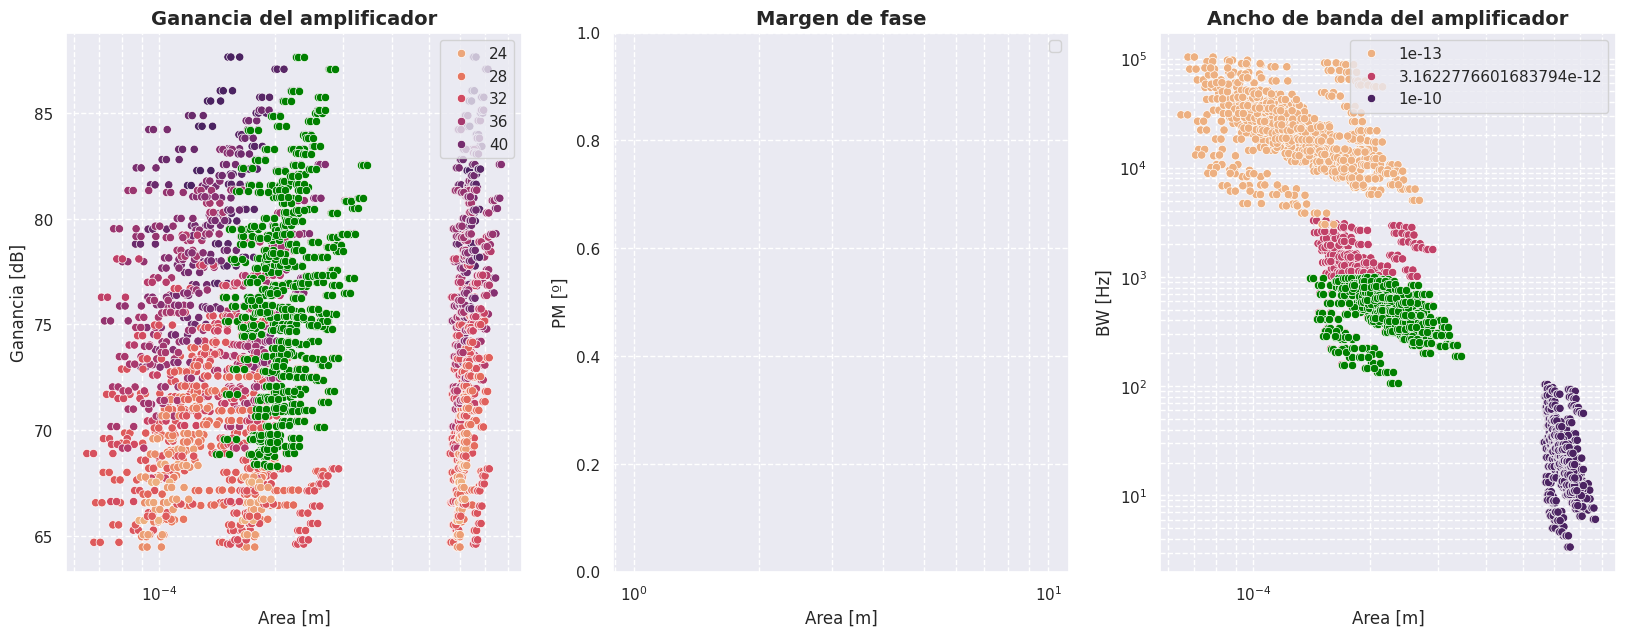

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare', hue="gain_2stage")
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
#sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
#sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue=Symbol("Cc"), hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('ota_explore_raw_3.svg', dpi=120)

In [55]:
ota_df_new.to_csv("data/SKY_lv_ota_exploration3_case1_98_10_10.csv")
ota_df_wc_new.to_csv("data/SKY_lv_ota_exploration3_case2_98_10_10.csv")

In [56]:
OTA_2stage_primitive_wc = Primitive(parameters={Symbol("Ra_2stage"): ota_df_wc[Symbol("Ra_2stage")].values,
                                  Symbol("gma_2stage"): ota_df_wc[Symbol("gma_2stage")].values,
                                  Symbol("Cin_2stage"): ota_df_wc[Symbol("Cin_2stage")].values,

                                  Symbol("Ra_1stage"): ota_df_wc[Symbol("Ra_1stage")].values,
                                  Symbol("gma_1stage"): ota_df_wc[Symbol("gma_1stage")].values,

                                  Symbol("Cc"): ota_df_wc[Symbol("Cc")].values,
                                  Symbol("Rc"): ota_df_wc[Symbol("Rc")].values,})

OTA_2stage_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_df_wc[Symbol("W_2stage")].values,
    Symbol("L_2stage"): ota_df_wc[Symbol("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_wc[Symbol("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_wc[Symbol("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_wc[Symbol("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_wc[Symbol("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_wc[Symbol("W_diff")].values,
    Symbol("L_diff"): ota_df_wc[Symbol("L_diff")].values,
    Symbol("vout_1stage"): ota_df_wc[Symbol("vout_1stage")].values,
    Symbol("W_al"): ota_df_wc[Symbol("W_al")].values,
    Symbol("L_al"): ota_df_wc[Symbol("L_al")].values,
    Symbol("W_cs"): ota_df_wc[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df_wc[Symbol("L_cs")].values,
    Symbol("vgs_cs"): ota_df_wc[Symbol("vgs_cs")].values,
    
    Symbol("W_cc"): ota_df_wc[Symbol("W_cc")].values,
    Symbol("L_cc"): ota_df_wc[Symbol("L_cc")].values,
    
    Symbol("W_rc"): ota_df_wc[Symbol("W_rc")].values,
    Symbol("L_rc"): ota_df_wc[Symbol("L_rc")].values}

In [57]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt_wc}    

OTA_macro.ext_mask = None

OTA_macro.primitives = [OTA_2stage_primitive_wc]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA, phase_margin_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df_wc, mask_ota = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.029902219772338867
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.024984121322631836
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.029978513717651367
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of phase_margin_OTA took: 0.029166698455810547
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7effcdb6b4

In [58]:
OTA_2stage_primitive = Primitive(parameters={Symbol("Ra_2stage"): ota_df[Symbol("Ra_2stage")].values,
                                  Symbol("gma_2stage"): ota_df[Symbol("gma_2stage")].values,
                                  Symbol("Cin_2stage"): ota_df[Symbol("Cin_2stage")].values,

                                  Symbol("Ra_1stage"): ota_df[Symbol("Ra_1stage")].values,
                                  Symbol("gma_1stage"): ota_df[Symbol("gma_1stage")].values,

                                  Symbol("Cc"): ota_df[Symbol("Cc")].values,
                                  Symbol("Rc"): ota_df[Symbol("Rc")].values,})
OTA_2stage_primitive.outputs = {
    Symbol("W_2stage"): ota_df[Symbol("W_2stage")].values,
    Symbol("L_2stage"): ota_df[Symbol("L_2stage")].values,
    Symbol("vin_2stage"): ota_df[Symbol("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df[Symbol("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df[Symbol("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df[Symbol("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df[Symbol("W_diff")].values,
    Symbol("L_diff"): ota_df[Symbol("L_diff")].values,
    Symbol("vout_1stage"): ota_df[Symbol("vout_1stage")].values,
    Symbol("W_al"): ota_df[Symbol("W_al")].values,
    Symbol("L_al"): ota_df[Symbol("L_al")].values,
    Symbol("W_cs"): ota_df[Symbol("W_cs")].values,
    Symbol("L_cs"): ota_df[Symbol("L_cs")].values,
    Symbol("vgs_cs"): ota_df[Symbol("vgs_cs")].values,
    
    Symbol("W_cc"): ota_df[Symbol("W_cc")].values,
    Symbol("L_cc"): ota_df[Symbol("L_cc")].values,
    
    Symbol("W_rc"): ota_df[Symbol("W_rc")].values,
    Symbol("L_rc"): ota_df[Symbol("L_rc")].values}

In [59]:
phase_margin_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("Vpos"): 1,
    Symbol("Cin_pt"): Cin_pt}    

OTA_macro.ext_mask = mask_ota

OTA_macro.primitives = [OTA_2stage_primitive]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [gain_OTA, rout_OTA, gm_OTA, phase_margin_OTA]
OTA_macro.opt_specifications = [gain_OTA]
OTA_macro.is_primitive = 0
OTA_macro.run_pareto = False

_, _, _, ota_df, _ = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  OpAmp_2stage
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gain_OTA took: 0.028202533721923828
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage_rout
Running MNA... 
MNA of rout_OTA took: 0.03711366653442383
   net1  vss  vpos  vout  net2  vr
0     1    0     2     3     4   5
[['vout', 'vr']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of gm_OTA took: 0.030852556228637695
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
Netlist:  OpAmp_2stage
Running MNA... 
MNA of phase_margin_OTA took: 0.02346944808959961
   net1  vss  vpos  vout  net2
0     1    0     2     3     4
[['vout', 'vpos']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
-Ra_1stage*Ra_2stage*gma_1stage*gma_2stage
lambdify variables: (Ra_2stage, gma_2stage, Cin_2stage, Ra_1stage, gma_1stage, Cc, Rc) <function _lambdifygenerated at 0x7effd6723eb0

In [60]:
ota_df["gain"] = 20*np.log10(ota_df["gain_OTA"])
ota_df["gain_wc"] = 20*np.log10(ota_df_wc["gain_OTA"])

ota_df["gain_1stage"] = 20*np.log10(ota_df[Symbol("Ra_1stage")]*ota_df[Symbol("gma_1stage")])
ota_df["gain_2stage"] = 20*np.log10(ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("gma_2stage")])
ota_df["bw"] = 1/(2*np.pi*ota_df[Symbol("Ra_1stage")]*(ota_df[Symbol("Cin_2stage")]+ota_df[Symbol("gma_2stage")]*ota_df[Symbol("Ra_2stage")]*ota_df[Symbol("Cc")]))

ota_df["bw_wc"] = 1/(2*np.pi*ota_df_wc[Symbol("Ra_1stage")]*(ota_df_wc[Symbol("Cin_2stage")]+ota_df_wc[Symbol("gma_2stage")]*ota_df_wc[Symbol("Ra_2stage")]*ota_df_wc[Symbol("Cc")]))

ota_df["phase_margin_OTA_wc"] = ota_df_wc["phase_margin_OTA"]

ota_df_wc["gain"] =  20*np.log10(ota_df_wc["gain_OTA"])

ota_df_new = ota_df[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80)) 
                                                        | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80))]
ota_df_wc_new = ota_df_wc[((ota_df["bw"]>500) & (ota_df["bw"]<1000) & (ota_df["gain"]>64.44) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80)) 
                                                        | ((ota_df["bw"]>100) & (ota_df["bw"]<1000) & (ota_df["gain"]>73.33) & (ota_df["phase_margin_OTA_wc"]>60) & (ota_df["phase_margin_OTA"]>80))]

ota_df_new.sort_values(by="gain")

Ra_2stage  gma_2stage    Cin_2stage     Ra_1stage  gma_1stage  \
2374  218805.893032    0.000077  1.781634e-14  3.024345e+06    0.000051   
250   439278.239328    0.000082  8.370936e-14  1.429257e+06    0.000054   
88    469879.338088    0.000077  1.781634e-14  1.429260e+06    0.000054   
1186  283014.712980    0.000082  8.370936e-14  2.383247e+06    0.000051   
1006  301810.520803    0.000077  1.781634e-14  2.383419e+06    0.000051   
...             ...         ...           ...           ...         ...   
1825  970768.821234    0.000050  2.969312e-14  3.243014e+06    0.000051   
2608  664535.860261    0.000082  8.370936e-14  3.024653e+06    0.000051   
1231  916312.845291    0.000082  8.370936e-14  2.383423e+06    0.000051   
2545  916312.845291    0.000082  8.370936e-14  2.385395e+06    0.000054   
2617  916312.845291    0.000082  8.370936e-14  3.024564e+06    0.000051   

                Cc        Rc      gain_OTA       rout_OTA    gm_OTA  ...  \
2374  3.162278e-12  100000.0   2609.580649  218805.893032  0.011926  ...   
250   3.162278e-12  100000.0   2748.972238  439278.239328  0.006258  ...   
88    3.162278e-12  100000.0   2785.311056  469879.338088  0.005928  ...   
1186  3.162278e-12  100000.0   2804.869152  283014.712980  0.009911  ...   
1006  3.162278e-12  100000.0   2833.159834  301810.520803  0.009387  ...   
...            ...       ...           ...            ...       ...  ...   
1825  3.162278e-12  100000.0   8033.037460  970768.821234  0.008275  ...   
2608  3.162278e-12  100000.0   8366.704476  664535.860261  0.012590  ...   
1231  3.162278e-12  100000.0   9080.760497  916312.845291  0.009910  ...   
2545  3.162278e-12  100000.0   9601.968215  916312.845291  0.010479  ...   
2617  3.162278e-12  100000.0  11536.789974  916312.845291  0.012590  ...   

          W_rc          L_rc      area       gain    gain_wc  gain_1stage  \
2374  0.000012  5.000000e-07  0.000202  68.331414  61.476346    43.764377   
250   0.000012  5.000000e-07  0.000186  68.783407  60.270054    37.691910   
88    0.000012  5.000000e-07  0.000151  68.897474  57.711746    37.691890   
1186  0.000012  5.000000e-07  0.000191  68.958252  62.822569    41.685369   
1006  0.000012  5.000000e-07  0.000193  69.045422  60.457087    41.684877   
...        ...           ...       ...        ...        ...          ...   
1825  0.000012  5.000000e-07  0.000164  78.097596  52.754750    44.383903   
2608  0.000012  5.000000e-07  0.000299  78.451089  67.397125    43.764017   
1231  0.000012  5.000000e-07  0.000174  79.162444  66.041123    41.684866   
2545  0.000012  5.000000e-07  0.000184  79.647205  66.488528    42.169627   
2617  0.000012  5.000000e-07  0.000191  81.241700  68.094327    43.764121   

      gain_2stage          bw        bw_wc  phase_margin_OTA_wc  
2374    24.567038  983.314274  2164.238720            91.975121  
250     31.091497  981.328514  2611.756334            84.410237  
88      31.205584  969.086009  3511.727733            91.603093  
1186    27.272883  913.081354  1848.213467            84.908991  
1006    27.360545  904.664634  2430.848336            91.993139  
...           ...         ...          ...                  ...  
1825    33.713693  319.965043  5898.942213            84.325803  
2608    34.687071  306.604873  1093.252436            84.051429  
1231    37.477578  282.219100  1276.729042            84.043771  
2545    37.477578  281.985841  1281.200917            83.542243  
2617    37.477578  222.394852  1009.114759            83.984364  

[67 rows x 37 columns]

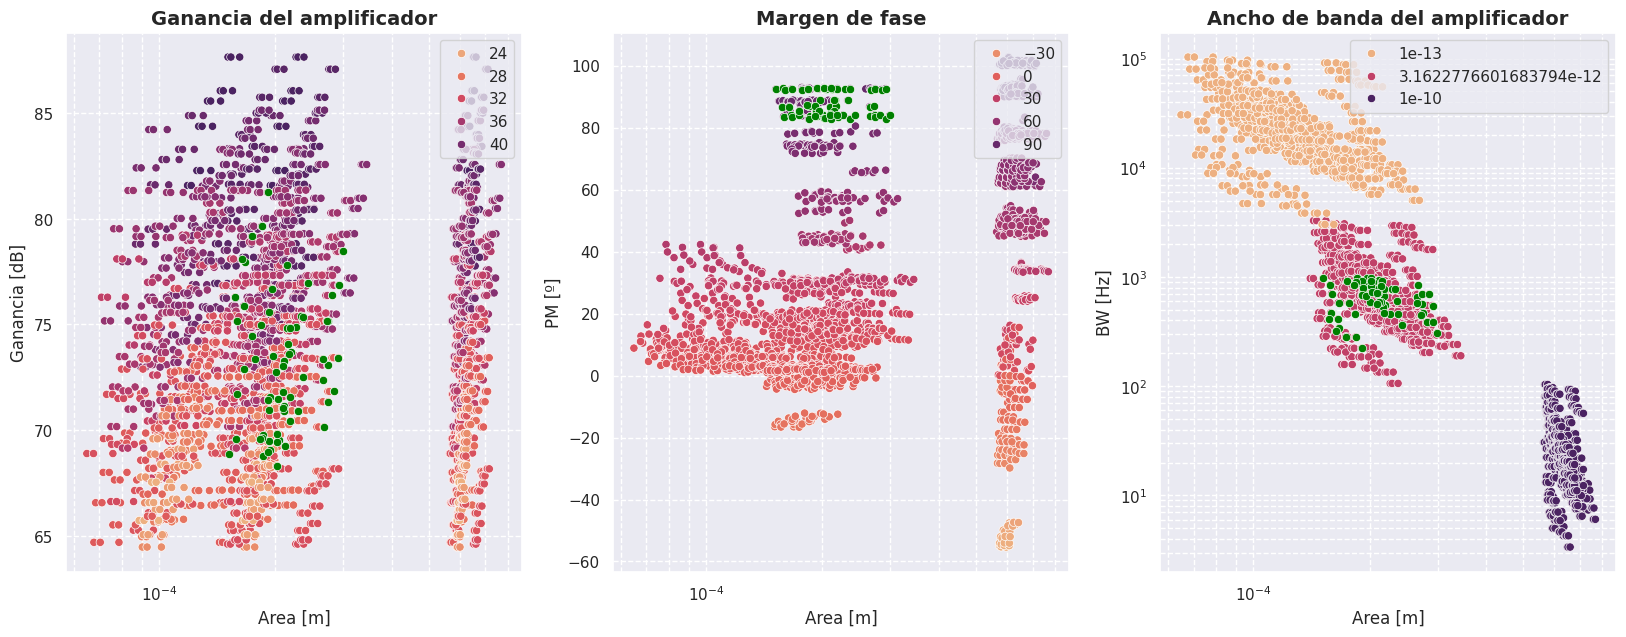

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
sns.scatterplot(ax=axs[0], data=ota_df, x='area', y='gain', palette='flare', hue="gain_2stage")
sns.scatterplot(ax=axs[0], data=ota_df_new, x='area', y='gain', color="green")
sns.scatterplot(ax=axs[1], data=ota_df, x="area", y="phase_margin_OTA", hue="phase_margin_OTA_wc", palette='flare')
sns.scatterplot(ax=axs[1], data=ota_df_new, x="area", y="phase_margin_OTA", color="green")
sns.scatterplot(ax=axs[2], data=ota_df, x="area", y="bw", hue=Symbol("Cc"), hue_norm=LogNorm(), palette='flare')
sns.scatterplot(ax=axs[2], data=ota_df_new, x="area", y="bw", color="green")

axs[0].set_title(r"Ganancia del amplificador", fontsize=14, weight='bold')
axs[0].set_xlabel(r"Area [m]")
axs[0].set_ylabel(r"Ganancia [dB]")
axs[0].locator_params(axis='x', nbins=10) 
axs[0].legend(loc = 'upper right')

axs[1].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1].set_xlabel(r"Area [m]")
axs[1].set_ylabel(r"PM [º]")
axs[1].legend(loc = 'upper right')

axs[2].set_xlabel(r"Area [m]")
axs[2].set_ylabel(r"BW [Hz]")
axs[2].set_title(r"Ancho de banda del amplificador", fontsize=14, weight='bold')
axs[2].legend(loc = 'upper right')

axs[0].grid(True,which="both",ls="--")  
axs[1].grid(True,which="both",ls="--")  
axs[2].grid(True,which="both",ls="--")  

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[2].set_xscale('log')

axs[2].set_yscale('log')

#sns.move_legend(axs[0], "upper left",title="ganancia segunda etapa")

plt.savefig('ota_explore_raw_3_sky.pdf')

In [62]:
ota_df_new.to_csv("data/SKY_lv_ota_exploration3_case1_98_10_10.csv")
ota_df_wc_new.to_csv("data/SKY_lv_ota_exploration3_case2_98_10_10.csv")

# LDO

In [25]:
ota_df_new = pd.read_csv("data/SKY_lv_ota_exploration3_case1_98_10_10.csv")
ota_df_wc_new = pd.read_csv("data/SKY_lv_ota_exploration3_case2_98_10_10.csv")

In [26]:
OTA_primitive_wc = Primitive(
    parameters={
        Symbol("Ra"): ota_df_wc_new["rout_OTA"].values,
        Symbol("gma"): ota_df_wc_new["gm_OTA"].values,
        Symbol("Ra_1stage"): ota_df_wc_new[("Ra_1stage")].values,
        Symbol("gma_1stage"): ota_df_wc_new[("gma_1stage")].values,
        Symbol("Ra_2stage"): ota_df_wc_new[("Ra_2stage")].values,
        Symbol("gma_2stage"): ota_df_wc_new[("gma_2stage")].values,
        Symbol("Cin_2stage"): ota_df_wc_new[("Cin_2stage")].values,
        Symbol("Rc_2stage"): ota_df_wc_new[("Rc")].values,
        Symbol("Cc_2stage"): ota_df_wc_new[("Cc")].values,
    }
)

OTA_primitive_wc.outputs = {
    Symbol("W_2stage"): ota_df_wc_new[("W_2stage")].values,
    Symbol("L_2stage"): ota_df_wc_new[("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_wc_new[("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_wc_new[("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_wc_new[("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_wc_new[("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_wc_new[("W_diff")].values,
    Symbol("L_diff"): ota_df_wc_new[("L_diff")].values,
    Symbol("vout_1stage"): ota_df_wc_new[("vout_1stage")].values,
    Symbol("W_al"): ota_df_wc_new[("W_al")].values,
    Symbol("L_al"): ota_df_wc_new[("L_al")].values,
    Symbol("W_cs"): ota_df_wc_new[("W_cs")].values,
    Symbol("L_cs"): ota_df_wc_new[("L_cs")].values,
    Symbol("vgs_cs"): ota_df_wc_new[("vgs_cs")].values,
}

In [90]:
ldo_df_new

Ra       gma     Ra_1stage  gma_1stage      Ra_2stage  \
0    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
1    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
2    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
3    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
4    469879.338088  0.006428  1.635692e+06    0.000051  469879.338088   
..             ...       ...           ...         ...            ...   
263  664535.860261  0.012590  3.024653e+06    0.000051  664535.860261   
264  916312.845291  0.012590  3.024564e+06    0.000051  916312.845291   
265  916312.845291  0.012590  3.024564e+06    0.000051  916312.845291   
266  916312.845291  0.012590  3.024564e+06    0.000051  916312.845291   
267  916312.845291  0.012590  3.024564e+06    0.000051  916312.845291   

     gma_2stage    Cin_2stage  Rc_2stage     Cc_2stage     gm_pt  ...  \
0      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
1      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
2      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
3      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
4      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
..          ...           ...        ...           ...       ...  ...   
263    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   
264    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   
265    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   
266    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   
267    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   

       gain_ol    psrr_wc  gain_ol_wc   Vota_wc  cin_pt_wc      gmid  \
0    82.012892 -54.674103   76.727111  1.507593   0.114702  5.991094   
1    82.012892 -54.674103   76.727111  1.507593   0.114702  5.991094   
2    82.012892 -54.674103   76.727111  1.507593   0.114702  5.991094   
3    82.012892 -54.674103   76.727111  1.507593   0.114702  5.991094   
4    82.717074 -55.408705   77.461850  1.507593   0.114702  5.991094   
..         ...        ...         ...       ...        ...       ...   
263  91.566507 -64.358348   86.412491  1.507593   0.114702  5.991094   
264  94.357118 -65.055507   87.109693  1.507593   0.114702  5.991094   
265  94.357118 -65.055507   87.109693  1.507593   0.114702  5.991094   
266  94.357118 -65.055507   87.109693  1.507593   0.114702  5.991094   
267  94.357118 -65.055507   87.109693  1.507593   0.114702  5.991094   

     phase_margin_LDO_wc   loadreg          bw   gain_ota  
0              89.983079  0.837809  956.116828  68.897474  
1              89.983138  0.837809  956.116828  68.897474  
2              89.983079  0.837809  956.116828  68.897474  
3              89.983138  0.837809  956.116828  68.897474  
4              89.980595  0.768911  835.450467  69.601656  
..                   ...       ...         ...        ...  
263            89.964283  0.273273  303.960997  78.451089  
264            89.964222  0.271623  221.000574  81.241700  
265            89.964281  0.271623  221.000574  81.241700  
266            89.964222  0.271623  221.000574  81.241700  
267            89.964281  0.271623  221.000574  81.241700  

[216 rows x 54 columns]

In [91]:
ldo_df_wc_new

Ra       gma     Ra_1stage  gma_1stage      Ra_2stage  \
0    134976.147829  0.005693  1.460403e+06    0.000054  134976.147829   
1    134976.147829  0.005693  1.460403e+06    0.000054  134976.147829   
2    134976.147829  0.005693  1.460403e+06    0.000054  134976.147829   
3    134976.147829  0.005693  1.460403e+06    0.000054  134976.147829   
4    134976.147829  0.006195  1.677295e+06    0.000051  134976.147829   
..             ...       ...           ...         ...            ...   
263  192963.656128  0.012145  3.039745e+06    0.000051  192963.656128   
264  209088.622017  0.012145  3.039653e+06    0.000051  209088.622017   
265  209088.622017  0.012145  3.039653e+06    0.000051  209088.622017   
266  209088.622017  0.012145  3.039653e+06    0.000051  209088.622017   
267  209088.622017  0.012145  3.039653e+06    0.000051  209088.622017   

     gma_2stage    Cin_2stage  Rc_2stage     Cc_2stage     gm_pt  ...  \
0      0.000073  1.888351e-14   100000.0  3.162278e-12  0.001308  ...   
1      0.000073  1.888351e-14   100000.0  3.162278e-12  0.001308  ...   
2      0.000073  1.888351e-14   100000.0  3.162278e-12  0.001308  ...   
3      0.000073  1.888351e-14   100000.0  3.162278e-12  0.001308  ...   
4      0.000073  1.888351e-14   100000.0  3.162278e-12  0.001308  ...   
..          ...           ...        ...           ...       ...  ...   
263    0.000078  8.849205e-14   100000.0  3.162278e-12  0.001308  ...   
264    0.000078  8.849205e-14   100000.0  3.162278e-12  0.001308  ...   
265    0.000078  8.849205e-14   100000.0  3.162278e-12  0.001308  ...   
266    0.000078  8.849205e-14   100000.0  3.162278e-12  0.001308  ...   
267    0.000078  8.849205e-14   100000.0  3.162278e-12  0.001308  ...   

         L_cs  vgs_cs      W_pt          L_pt      W_cc      L_cc      W_rc  \
0    0.000006     0.7  0.000726  4.000000e-07  0.000008  0.000008  0.000001   
1    0.000006     0.7  0.000726  4.000000e-07  0.000015  0.000015  0.000001   
2    0.000006     0.7  0.000726  4.000000e-07  0.000026  0.000026  0.000001   
3    0.000006     0.7  0.000726  4.000000e-07  0.000008  0.000008  0.000002   
4    0.000006     0.7  0.000726  4.000000e-07  0.000008  0.000008  0.000001   
..        ...     ...       ...           ...       ...       ...       ...   
263  0.000006     0.5  0.000726  4.000000e-07  0.000008  0.000008  0.000002   
264  0.000006     0.7  0.000726  4.000000e-07  0.000008  0.000008  0.000001   
265  0.000006     0.7  0.000726  4.000000e-07  0.000015  0.000015  0.000001   
266  0.000006     0.7  0.000726  4.000000e-07  0.000026  0.000026  0.000001   
267  0.000006     0.7  0.000726  4.000000e-07  0.000008  0.000008  0.000002   

             L_rc      area    gain_ol  
0    5.000000e-07  0.000791  76.727111  
1    5.000000e-07  0.000804  76.727111  
2    5.000000e-07  0.000827  76.727111  
3    5.000000e-07  0.000792  76.727111  
4    5.000000e-07  0.000798  77.461850  
..            ...       ...        ...  
263  5.000000e-07  0.000939  86.412491  
264  5.000000e-07  0.000831  87.109693  
265  5.000000e-07  0.000843  87.109693  
266  5.000000e-07  0.000866  87.109693  
267  5.000000e-07  0.000832  87.109693  

[216 rows x 44 columns]

In [27]:
pt_2 = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0304048029485101]),
        Symbol('Ro_pt'): np.asarray([401.96637136321897]),
        Symbol("Cgg_pt"): np.asarray([1.567114848542521e-12]),
        Symbol("Cgd_pt"): np.asarray([7.650244072854094e-16]),
        Symbol("Cin_pt"): np.asarray([1.5764647537008622e-12]),
        Symbol("dropout"): np.asarray([0.333828836752825]),
        Symbol('Vota'): np.asarray([1.122222222222])
    }
)

pt_2.outputs = {
    Symbol("W_pt"): np.asarray([0.0007258641413085]),
    Symbol("L_pt"): np.asarray([4e-7])
}

pt_2_wc = Primitive(
    parameters={
        Symbol('gm_pt'): np.asarray([0.0013077388196833]),
        Symbol('Ro_pt'): np.asarray([11908.821884659845]),
        Symbol("Cgg_pt"): np.asarray([6.440992414275248e-13]),
        Symbol("Cgd_pt"): np.asarray([2.3663566049641697e-17]),
        Symbol("Cin_pt"): np.asarray([0.1147018026400135]),
        Symbol("dropout"): np.asarray([0.1147018026400135]),
        Symbol('Vota'): np.asarray([1.5075934460298])
    }
)

pt_2_wc.outputs = {
    Symbol("W_pt"): np.asarray([0.0007258641413085]),
    Symbol("L_pt"): np.asarray([4e-7])
}

In [28]:
Cc_primitive_LDO_2 = Primitive(
    parameters={
        Symbol("Cc"): np.asarray([3.1622776601683798e-12, 1e-12, 3.1622e-12, 1e-12]),
        Symbol("Rc"): np.asarray([1000.0, 1000, 3162, 3162])
    }
)

Cc_primitive_LDO_2.outputs = {
    Symbol("W_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("L_cc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Cc")]/1.5e-15)*1e-6,
    Symbol("W_rc"): np.sqrt(Cc_primitive_LDO.parameters[Symbol("Rc")]/(1360*0.5))*1e-6,
    Symbol("L_rc"): np.repeat(0.5e-6, 4)
}

In [29]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): 1000000000000,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol_pm"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): 1000000000000,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

LDO_macro.ext_mask = None

LDO_macro.primitives = [OTA_primitive_wc, pt_2_wc, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df_wc, ldo_mask_wc = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  LDO_macro
Netlist:  ldo
Running MNA... 
MNA of psrr_LDO took: 0.029931068420410156
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
MNA of dc_LDO took: 0.022626876831054688
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
MNA of gain_ol_LDO took: 0.01931619644165039
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol_pm
Running MNA... 
MNA of phase_margin_LDO took: 0.025179386138916016
   vss  vout  net1  vfb  net2  vol  net4  net3
0    0     1     2    3     4    5     6     7
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(1.6e+16*Ro_pt*gm_pt + 1.6e+16)/(1.2e+16*Ra*Ro_pt*gm_pt*gma + 1000000016000.0*Ro_pt + 1.6e+16)
lambdify variables: (Ra, gma, Ra_1stage, gma_1stage, Ra_2stage, gm

In [30]:
OTA_primitive = Primitive(
    parameters={
        Symbol("Ra"): ota_df_new["rout_OTA"],
        Symbol("gma"): ota_df_new["gm_OTA"],
        Symbol("Ra_1stage"): ota_df_new[("Ra_1stage")],
        Symbol("gma_1stage"): ota_df_new[("gma_1stage")],
        Symbol("Ra_2stage"): ota_df_new[("Ra_2stage")],
        Symbol("gma_2stage"): ota_df_new[("gma_2stage")],
        Symbol("Cin_2stage"): ota_df_new[("Cin_2stage")],
        Symbol("Rc_2stage"): ota_df_new[("Rc")],
        Symbol("Cc_2stage"): ota_df_new[("Cc")],
    }
)

OTA_primitive.outputs = {
    Symbol("W_2stage"): ota_df_new[("W_2stage")].values,
    Symbol("L_2stage"): ota_df_new[("L_2stage")].values,
    Symbol("vin_2stage"): ota_df_new[("vin_2stage")].values,
    Symbol("W_cs_2stage"): ota_df_new[("W_cs_2stage")].values,
    Symbol("L_cs_2stage"): ota_df_new[("L_cs_2stage")].values,
    Symbol("vgs_cs_2stage"): ota_df_new[("vgs_cs_2stage")].values,
    
    Symbol("W_diff"): ota_df_new[("W_diff")].values,
    Symbol("L_diff"): ota_df_new[("L_diff")].values,
    Symbol("vout_1stage"): ota_df_new[("vout_1stage")].values,
    Symbol("W_al"): ota_df_new[("W_al")].values,
    Symbol("L_al"): ota_df_new[("L_al")].values,
    Symbol("W_cs"): ota_df_new[("W_cs")].values,
    Symbol("L_cs"): ota_df_new[("L_cs")].values,
    Symbol("vgs_cs"): ota_df_new[("vgs_cs")].values,
}

In [31]:
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

dc_LDO_macro.parametros = {Symbol("V1"): Vin,
                           Symbol("V2"): Vref,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol_pm"
phase_margin_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}


LDO_macro.ext_mask = ldo_mask_wc

LDO_macro.primitives = [OTA_primitive, pt_2, Cc_primitive_LDO_2]
LDO_macro.submacromodels = []
LDO_macro.num_level_exp = 1
LDO_macro.specifications = [psrr_LDO_macro, dc_LDO_macro, gain_ol_LDO_macro, phase_margin_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

_, _, _, ldo_df, _ = dfs(LDO_macro, debug = False)

############################################
Starting the exploration of:  ldo_ol_pm
Netlist:  ldo
Running MNA... 
MNA of psrr_LDO took: 0.03182339668273926
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo
Running MNA... 
MNA of dc_LDO took: 0.02193737030029297
   vdd  vout  net1  vfb  vss  net2
0    1     2     3    4    0     5
[['vout', 'vdd']]
Netlist:  ldo_ol
Running MNA... 
MNA of gain_ol_LDO took: 0.022579669952392578
   vss  vout  net1  vfb  vol  net2
0    0     1     2    3    4     5
[['vout', 'vol']]
Netlist:  ldo_ol_pm
Running MNA... 
MNA of phase_margin_LDO took: 0.0303647518157959
   vss  vout  net1  vfb  net2  vol  net4  net3
0    0     1     2    3     4    5     6     7
[['vout', 'vol']]
older order of submacros:  []
new order of submacros:  []
[]
in eval
(3840000.0*Ro_pt*gm_pt + 3840000.0)/(2880000.0*Ra*Ro_pt*gm_pt*gma + 16240.0*Ro_pt + 3840000.0)
lambdify variables: (Ra, gma, Ra_1stage, gma_1stage, Ra_2stage, gma_2

In [32]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["gain_ol"] = 20*np.log10(ldo_df["gain_ol_LDO"])  
ldo_df_new = ldo_df[(ldo_df[Symbol("dropout")]<0.4) & (ldo_df["phase_margin_LDO"]>60) & (ldo_df["phase_margin_LDO"]<100)]
ldo_df_new

Ra       gma     Ra_1stage  gma_1stage      Ra_2stage  \
0    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
1    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
3    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
4    469879.338088  0.006428  1.635692e+06    0.000051  469879.338088   
5    469879.338088  0.006428  1.635692e+06    0.000051  469879.338088   
..             ...       ...           ...         ...            ...   
258  559764.342070  0.012590  3.024625e+06    0.000051  559764.342070   
260  664535.860261  0.012590  3.024653e+06    0.000051  664535.860261   
262  664535.860261  0.012590  3.024653e+06    0.000051  664535.860261   
264  916312.845291  0.012590  3.024564e+06    0.000051  916312.845291   
266  916312.845291  0.012590  3.024564e+06    0.000051  916312.845291   

     gma_2stage    Cin_2stage  Rc_2stage     Cc_2stage     gm_pt  ...  vgs_cs  \
0      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...     0.7   
1      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...     0.7   
3      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...     0.7   
4      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...     0.7   
5      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...     0.7   
..          ...           ...        ...           ...       ...  ...     ...   
258    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...     0.5   
260    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...     0.5   
262    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...     0.5   
264    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...     0.7   
266    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...     0.7   

         W_pt          L_pt      W_cc      L_cc      W_rc          L_rc  \
0    0.000726  4.000000e-07  0.000008  0.000008  0.000001  5.000000e-07   
1    0.000726  4.000000e-07  0.000015  0.000015  0.000001  5.000000e-07   
3    0.000726  4.000000e-07  0.000008  0.000008  0.000002  5.000000e-07   
4    0.000726  4.000000e-07  0.000008  0.000008  0.000001  5.000000e-07   
5    0.000726  4.000000e-07  0.000015  0.000015  0.000001  5.000000e-07   
..        ...           ...       ...       ...       ...           ...   
258  0.000726  4.000000e-07  0.000026  0.000026  0.000001  5.000000e-07   
260  0.000726  4.000000e-07  0.000008  0.000008  0.000001  5.000000e-07   
262  0.000726  4.000000e-07  0.000026  0.000026  0.000001  5.000000e-07   
264  0.000726  4.000000e-07  0.000008  0.000008  0.000001  5.000000e-07   
266  0.000726  4.000000e-07  0.000026  0.000026  0.000001  5.000000e-07   

         area       psrr    gain_ol  
0    0.000791 -65.716505  82.012892  
1    0.000804 -65.716505  82.012892  
3    0.000792 -65.716505  82.012892  
4    0.000798 -66.420615  82.717074  
5    0.000811 -66.420615  82.717074  
..        ...        ...        ...  
258  0.000918 -73.779333  90.076276  
260  0.000938 -75.269506  91.566507  
262  0.000974 -75.269506  91.566507  
264  0.000831 -78.060034  94.357118  
266  0.000866 -78.060034  94.357118  

[180 rows x 45 columns]

In [33]:
ldo_df["psrr"] = 20*np.log10(ldo_df["psrr_LDO"])
ldo_df["psrr_wc"] = 20*np.log10(ldo_df_wc["psrr_LDO"])

ldo_df['gain_ol'] = 20*np.log10(ldo_df['gain_ol_LDO'])
ldo_df['gain_ol_wc'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

ldo_df["Vota_wc"] = ldo_df_wc[Symbol("Vota")]
ldo_df["cin_pt_wc"] = ldo_df_wc[Symbol("Cin_pt")]

ldo_df['gmid'] = ldo_df[Symbol('gm_pt')]/pt.inputs['il']

ldo_df["phase_margin_LDO_wc"] = ldo_df_wc["phase_margin_LDO"]

ldo_df['loadreg'] = np.abs(ldo_df['dc_LDO']-ldo_df_wc['dc_LDO'])/IL

ldo_df["bw"] = 1/(2*np.pi*ldo_df[Symbol("Ra_1stage")]*(ldo_df[Symbol("Cin_pt")]+ldo_df[Symbol("gma_2stage")]*ldo_df[Symbol("Ra_2stage")]*ldo_df[Symbol("Cc_2stage")]))    
ldo_df["gain_ota"] = 20*np.log10(ldo_df[Symbol("Ra")]*ldo_df[Symbol("gma")])

#ldo_df = ldo_df[(ldo_df["gain_ota"]>20) & (ldo_df[Symbol("W_pt")]<0.6e-3) & (ldo_df[Symbol("dropout")]<0.4)]

ldo_df_new = ldo_df[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>10) & (ldo_df[Symbol("W_pt")]<1e-3) & (ldo_df["loadreg"]<1) )]
#ldo_df_new = ldo_df
ldo_df_new.sort_values(by="area")

Ra       gma     Ra_1stage  gma_1stage      Ra_2stage  \
0    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
3    469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
4    469879.338088  0.006428  1.635692e+06    0.000051  469879.338088   
20   916312.845291  0.006258  1.429260e+06    0.000054  916312.845291   
7    469879.338088  0.006428  1.635692e+06    0.000051  469879.338088   
..             ...       ...           ...         ...            ...   
114  664535.860261  0.009910  2.383495e+06    0.000051  664535.860261   
182  393439.738524  0.009926  2.385487e+06    0.000054  393439.738524   
206  393439.738524  0.011926  3.024653e+06    0.000051  393439.738524   
238  664535.860261  0.010479  2.385487e+06    0.000054  664535.860261   
262  664535.860261  0.012590  3.024653e+06    0.000051  664535.860261   

     gma_2stage    Cin_2stage  Rc_2stage     Cc_2stage     gm_pt  ...  \
0      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
3      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
4      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
20     0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   
7      0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
..          ...           ...        ...           ...       ...  ...   
114    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   
182    0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
206    0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
238    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   
262    0.000082  8.370936e-14   100000.0  3.162278e-12  0.030405  ...   

       gain_ol    psrr_wc  gain_ol_wc   Vota_wc  cin_pt_wc      gmid  \
0    82.012892 -54.674103   76.727111  1.507593   0.114702  5.991094   
3    82.012892 -54.674103   76.727111  1.507593   0.114702  5.991094   
4    82.717074 -55.408705   77.461850  1.507593   0.114702  5.991094   
20   88.284887 -59.031151   81.084825  1.507593   0.114702  5.991094   
7    82.717074 -55.408705   77.461850  1.507593   0.114702  5.991094   
..         ...        ...         ...       ...        ...       ...   
114  89.487151 -62.305191   84.359186  1.507593   0.114702  5.991094   
182  84.948368 -58.572416   80.626035  1.507593   0.114702  5.991094   
206  86.542857 -60.190300   82.244102  1.507593   0.114702  5.991094   
238  89.972018 -62.752668   84.806698  1.507593   0.114702  5.991094   
262  91.566507 -64.358348   86.412491  1.507593   0.114702  5.991094   

     phase_margin_LDO_wc   loadreg          bw   gain_ota  
0              89.983079  0.456987  956.116828  68.897474  
3              89.983138  0.456987  956.116828  68.897474  
4              89.980595  0.419406  835.450467  69.601656  
20             89.982893  0.296016  467.675857  75.169468  
7              89.980654  0.419406  835.450467  69.601656  
..                   ...       ...         ...        ...  
114            89.971680  0.188600  385.726372  76.371733  
182            89.972283  0.279680  682.358718  71.832950  
206            89.964812  0.231891  538.163327  73.427439  
238            89.971778  0.179408  385.404256  76.856599  
262            89.964224  0.149058  303.960997  78.451089  

[224 rows x 54 columns]

In [34]:
ldo_df_wc_new = ldo_df_wc[((ldo_df[Symbol("dropout")]<0.4) & (ldo_df["psrr"]<-60) & (ldo_df["phase_margin_LDO_wc"]>60) & (ldo_df["bw"]>100) & (ldo_df[Symbol("W_pt")]<1e-3)  & (ldo_df["loadreg"]<1))]
ldo_df_wc_new['gain_ol'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])

/tmp/ipykernel_20233/882397663.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldo_df_wc_new['gain_ol'] = 20*np.log10(ldo_df_wc['gain_ol_LDO'])


In [35]:
pareto_dict = {"area": ldo_df_new["area"].values, "pm": ldo_df_new["phase_margin_LDO_wc"].values}
pareto_df = pd.DataFrame(pareto_dict)

mask = pareto.paretoset(pareto_df, sense=["min", "max"])

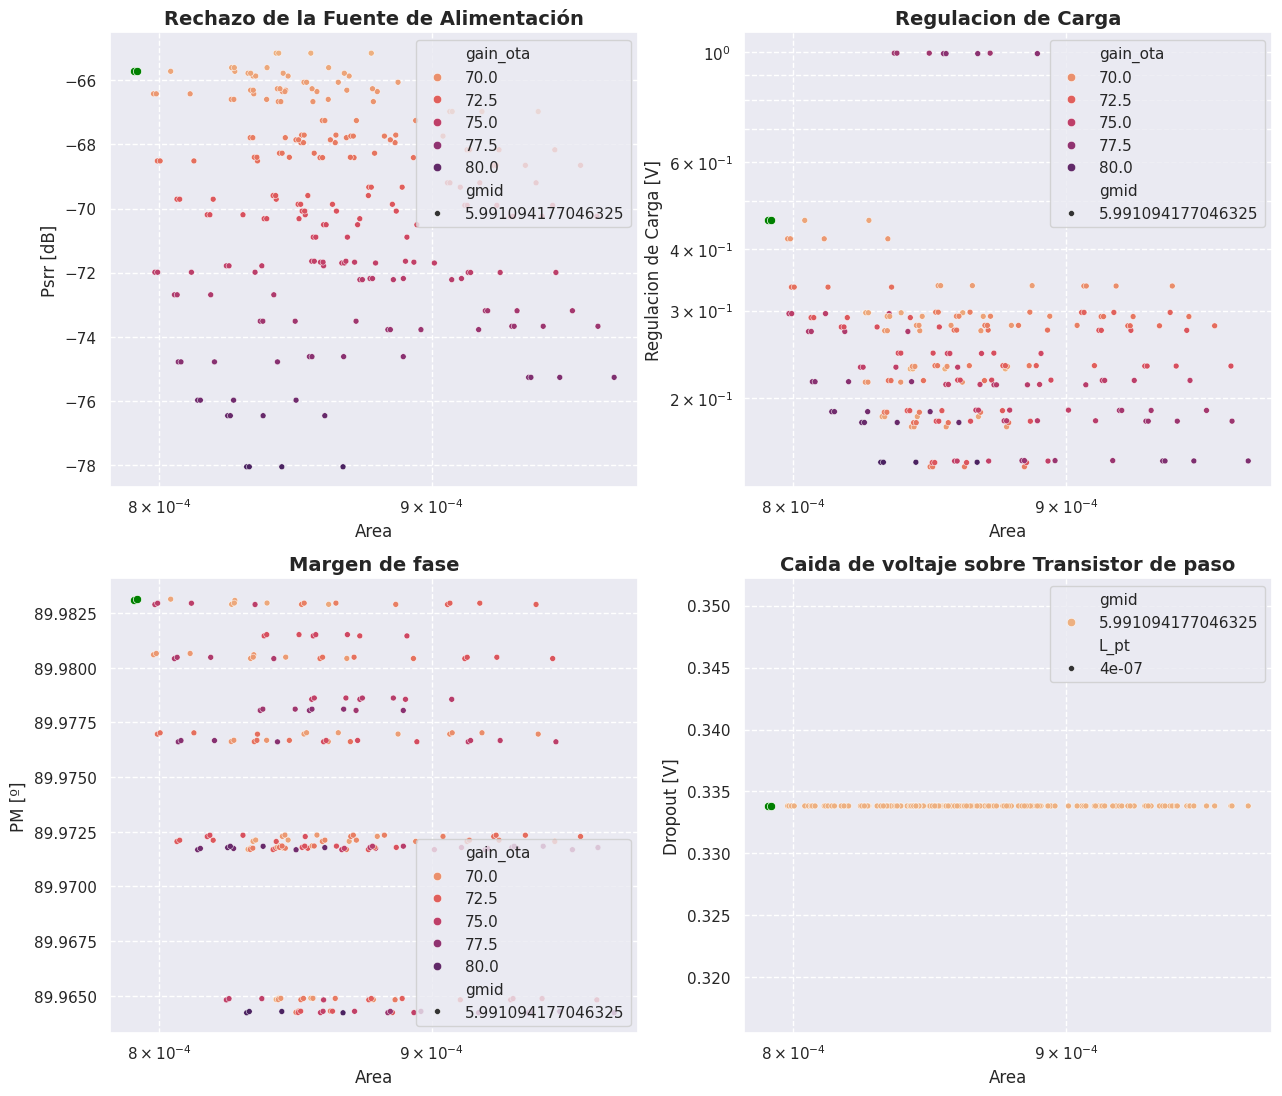

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13))
sns.scatterplot(ax=axs[0,0], data=ldo_df_new, x='area', y='psrr', palette='flare', hue='gain_ota', rasterized=True, size='gmid')
sns.scatterplot(ax=axs[0,0], data=ldo_df_new[mask], x='area', y='psrr', c='green')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new, x='area', y='loadreg', palette='flare', rasterized=True, hue='gain_ota', size='gmid')
sns.scatterplot(ax=axs[0,1], data=ldo_df_new[mask], x='area', y='loadreg', c='green')
sns.scatterplot(ax=axs[1,1], data=ldo_df_new, x='area', y=Symbol('dropout'), palette='flare', hue='gmid', rasterized=True, size=Symbol('L_pt'))
sns.scatterplot(ax=axs[1,1], data=ldo_df_new[mask], x='area', y=Symbol('dropout'), c='green')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new, x='area', y="phase_margin_LDO_wc", palette='flare', hue="gain_ota", rasterized=True, size='gmid')
sns.scatterplot(ax=axs[1,0], data=ldo_df_new[mask], x='area', y="phase_margin_LDO_wc", c='green')

axs[0,0].set_title(r"Rechazo de la Fuente de Alimentación", fontsize=14, weight='bold')
axs[0,0].set_xlabel(r"Area")
axs[0,0].set_ylabel(r"Psrr [dB]")
axs[0,0].locator_params(axis='x', nbins=10) 
axs[0,0].legend(loc = 'upper right')

axs[0,1].set_title(r"Regulacion de Carga", fontsize=14, weight='bold')
axs[0,1].set_xlabel(r"Area")
axs[0,1].set_ylabel(r"Regulacion de Carga [V]")
axs[0,1].legend(loc = 'upper right')

axs[1,1].set_xlabel(r"Area")
axs[1,1].set_ylabel(r"Dropout [V]")
axs[1,1].set_title(r"Caida de voltaje sobre Transistor de paso", fontsize=14, weight='bold')
axs[1,1].legend(loc = 'upper right')

axs[1,0].set_title(r"Margen de fase", fontsize=14, weight='bold')
axs[1,0].set_xlabel(r"Area")
axs[1,0].set_ylabel(r"PM [º]")
axs[1,0].legend(loc = 'upper right')
#fig.suptitle(r"Ganancias intrínsecas", fontsize=24, y=1.1)

axs[0,0].set_xscale('log')
axs[0,1].set_xscale('log')
axs[1,0].set_xscale('log')
axs[1,1].set_xscale('log')

axs[0,1].set_yscale('log')



axs[0,0].grid(True,which="both",ls="--")  
axs[0,1].grid(True,which="both",ls="--")  
axs[1,0].grid(True,which="both",ls="--")  
axs[1,1].grid(True,which="both",ls="--")  

sns.move_legend(axs[0,0], "upper right")
sns.move_legend(axs[0,1], "upper right")
sns.move_legend(axs[1,0], "lower right")
sns.move_legend(axs[1,1], "upper right")

plt.savefig('ldo_explore_raw_2_sky.pdf')

In [37]:
ldo_df_new[mask].to_csv("data/SKY_lv_ldo_final_98_10_10.csv")

In [38]:
ldo_df_new[mask]

Ra       gma     Ra_1stage  gma_1stage      Ra_2stage  \
0  469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   
3  469879.338088  0.005928  1.429260e+06    0.000054  469879.338088   

   gma_2stage    Cin_2stage  Rc_2stage     Cc_2stage     gm_pt  ...  \
0    0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   
3    0.000077  1.781634e-14   100000.0  3.162278e-12  0.030405  ...   

     gain_ol    psrr_wc  gain_ol_wc   Vota_wc  cin_pt_wc      gmid  \
0  82.012892 -54.674103   76.727111  1.507593   0.114702  5.991094   
3  82.012892 -54.674103   76.727111  1.507593   0.114702  5.991094   

   phase_margin_LDO_wc   loadreg          bw   gain_ota  
0            89.983079  0.456987  956.116828  68.897474  
3            89.983138  0.456987  956.116828  68.897474  

[2 rows x 54 columns]